<a href="https://colab.research.google.com/github/juan1t0/multimodalDLforER/blob/master/EmbraeNet_Plus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EmbraceNet+: Multi-modal DL method for Emotion Recognition

This notebook contains the execution (data preprocesing, training and testing) of the entire proposed method.
Non-current code is placed in xx and imported for convenience.

In [ ]:
!rm -r sample_data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Basic dependences

## Code

Downloading the source code from the [public repository](https://github.com/juan1t0/scofmer.git).

In [ ]:
!rm -r scofmer/

In [ ]:
scof_repo = 'https://github.com/juan1t0/multimodalDLforER.git'
!git clone $scof_repo

## InsighFace package

[InsightFace](http://insightface.ai/) provides implementations of state-of-the-art face analysis algorithms in computer vision.

First, the existing Cuda version is checked.

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


Acording to the cuda version, the [mxnet-cu](https://mxnet.apache.org/versions/1.4.1/install/ubuntu_setup.html) is installed. In this case, is used the version 10.1 (101).

In [ ]:
!pip install mxnet-cu101

     |███████████████████████████████▌| 834.1MB 1.2MB/s eta 0:00:10tcmalloc: large alloc 1147494400 bytes == 0x39828000 @  0x7f274ccb2615 0x591e47 0x4cc179 0x4cc2db 0x50a1cc 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50cc96 0x58e683 0x50c127 0x58e683 0x50c127 0x58e683 0x50c127 0x58e683 0x50c127 0x5095c8 0x50a2fd 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50beb4 0x5095c8 0x50a2fd
     |████████████████████████████████| 846.0MB 20kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


Following the official [documentation](http://insightface.ai/#installation.html), the insighface package is installed using `pip`.

In [ ]:
!pip install --upgrade insightface

  Created wheel for insightface: filename=insightface-0.1.5-cp36-none-any.whl size=16766 sha256=d4d82e48e60555119ebef1439b10b3ac6460af97c3a1f467720a013ccdcc94d2
  Stored in directory: /root/.cache/pip/wheels/11/b8/83/2bac12a833d66d58aa9705f5e7d94d2e9055f16f4698af0df7
Successfully built insightface


## High-Resolution Network

Importing the model from `models.basic_HRnet` module from `multimodalDLforER`. This model is originally from [leoxiaobin/deep-high-resolution-net](https://github.com/leoxiaobin/deep-high-resolution-net.pytorch.git) but some aspects was altered.

In [ ]:
from scofmer.models.basic_HRnet import SimpleHRNet as HRnet

The original repository also provides pre-trained models in COCO and MPII datasets. From his drive was copy the checkpoints of `hrnet_w48_384x288` and `hrnet_w32_384x288`.

In [ ]:
cpw48_dir = '/content/drive/MyDrive/Tesis-p/checkpoints/hrnet_w48_384x288.pth'
cpw32_dir = '/content/drive/MyDrive/Tesis-p/checkpoints/hrnet_w32_384x288.pth' # lighter

# Getting data

DATASET ([official page](http://sunai.uoc.edu/emotic/))

<img src="https://github.com/rkosti/emotic/blob/master/EMOTIC_mean_images/emotic_logo.png?raw=true" width="100" height="90" align="left" hspace="5" vspace = "2">

The EMOTIC dataset is a database of images with people in real environments, annotated with their apparent emotions. The images are annotated with an extended list of **26** emotion categories.

The images are raw and need some processing, the first one is getting/cutting the tagged person from each image. This is done just for practicality.

### Download

The emotic page provide the shared link to get the images and the simple download of annotations.

In [ ]:
!unzip '/content/drive/MyDrive/Tesis-p/emotic.zip'
!rm -r __MACOSX/

The annotations could be download directly from the [official page](http://sunai.uoc.edu/emotic/).

In [ ]:
!wget http://sunai.uoc.edu/emotic/emotic_files/annotations.zip
!unzip annotations.zip

!rm annotations.zip

## Processing

The original annotation file is in `*.mat` format. This format is not very practic and we opt to extract the important data in `*.csv` for the three sets: **train**, **val** \& **test**; for it is used the `mat2py` module. The script `mat2py.py` is originally implemented in [Tandon-A/emotic repository](https://github.com/Tandon-A/emotic), here is used an adapted version for process the data according to our establish modalities.


In [ ]:
from multimodalDLforER.utils.mat2py import prepare_data

### Models

First, create the **insightFace** and **HRnet** models

In [ ]:
import insightface
import cv2
import numpy as np

In [ ]:
fa_model = insightface.model_zoo.get_model('retinaface_r50_v1')

Model file is not found. Downloading.


100%|██████████| 107062/107062 [00:04<00:00, 23064.72KB/s]


Unlike the demo script from [tutorial](http://insightface.ai/build/examples_face_detection/demo_retinaface.html), change the ctx_id from `-1` to `0` for use cuda.

In [ ]:
fa_model.prepare(ctx_id = 0, nms=0.4)

[32, 16, 8] {'32': {'SCALES': (32, 16), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '16': {'SCALES': (8, 4), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '8': {'SCALES': (2, 1), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}}
use_landmarks True


For create HRnet, the defauld values are exploited.

In [ ]:
pose_model = HRnet(48, 17, cpw48_dir, multiperson=False, max_batch_size=2)

device: 'cuda' - 1 GPU(s) will be used


### Files

Now, the directory and every folder are generated.

In [ ]:
from os.path import join, exists

In [ ]:
newroot = 'Emotic_MultiDB'
sets = ['val', 'test', 'train']
annotationdir = 'Annotations'
modals = ['context', 'face', 'person','posture/joints','posture/bones']

if exists(newroot):
  os.system('rm -r ' + newroot)

for s in sets:
  for m in modals:
    if not exists(join(newroot,s,m)):
      os.makedirs(join(newroot,s,m))

if not exists(join(newroot, annotationdir)):
  os.makedirs(join(newroot, annotationdir))

In [ ]:
save_path = {'root':'Emotic_MultiDB', 'annotation':'Annotations',
             'cf':'context','pf':'person','ff':'face','jf':'posture/joints','bf':'posture/bones'}

### Generated of dataset for MER

Finally, the dataset of multi modalities are generated

In [ ]:
from scipy.io import loadmat
import csv 
import cv2
import numpy as np 
import os

In [ ]:
mat = loadmat('/content/annotations/Annotations.mat')
labels = ['val', 'test', 'train']
# labels = ['val']

In [ ]:
for label in labels:
  data_mat = mat[label]
  print ('starting label ', label)
  prepare_data(data_mat, 'emotic', save_path, dataset_type=label,
               fa_model=fa_model, pose_model=pose_model,generate_npy=True,debug_mode=False)

starting label  val
 Preprocessing data. Index =  0
 Preprocessing data. Index =  1000
 Preprocessing data. Index =  2000
Errors: 111 No exists: 0 Bad label 0
wrote file  Emotic_MultiDB/Annotations/val.csv
completed generating val data files
starting label  test
 Preprocessing data. Index =  0
 Preprocessing data. Index =  1000
 Preprocessing data. Index =  2000
 Preprocessing data. Index =  3000
 Preprocessing data. Index =  4000
 Preprocessing data. Index =  5000
 Preprocessing data. Index =  6000
 Preprocessing data. Index =  7000
Errors: 281 No exists: 0 Bad label 1
wrote file  Emotic_MultiDB/Annotations/test.csv
completed generating test data files
starting label  train
 Preprocessing data. Index =  0
 Preprocessing data. Index =  1000
 Preprocessing data. Index =  2000
 Preprocessing data. Index =  3000
 Preprocessing data. Index =  5000
 Preprocessing data. Index =  6000
 Preprocessing data. Index =  7000
 Preprocessing data. Index =  8000
 Preprocessing data. Index =  9000
 Pre

In [ ]:
del fa_model
del pose_model

### Saving the processing dataset

Once the generate all data, it is recommended to save the dataset in drive. For it first `zip` the dataset, and `copy` to any drive folder.

In [ ]:
!zip -r Emotic_MultiDB.zip Emotic_MultiDB/

In [ ]:
!cp Emotic_MultiDB.zip '/content/drive/My Drive/tesis/pp-dataset'

For future usage the dataset must to be `unzip` directly from drive save folder.

In [ ]:
!rm -r Emotic_MultiDB/

In [ ]:
!unzip '/content/drive/MyDrive/Tesis-p/pp-dataset/Emotic_MultiDB.zip'

There is an example of the data generated for each modality, the postural skeleton is not illustrated.

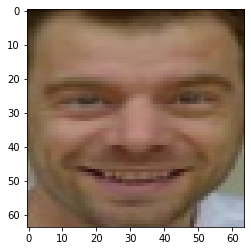

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

img = np.load('Emotic_MultiDB/val/face/face_002000.npy')
plt.imshow(img)

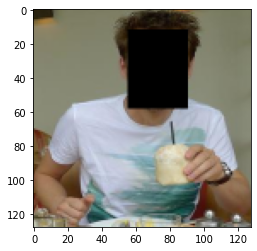

In [ ]:
img = np.load('Emotic_MultiDB/val/person/body_002000.npy')
plt.imshow(img)

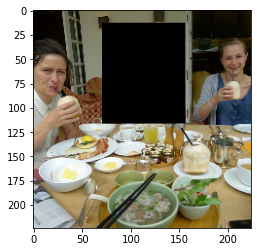

In [ ]:
img = np.load('Emotic_MultiDB/val/context/cntx_002000.npy')
plt.imshow(img)

# Getting models

In [ ]:
import torch
import torch.nn as nn
import numpy as np

In [ ]:
device = torch.device('cuda') # torch.device('cuda:0')

### ABN models for BODY & CONTEXT

In [ ]:
from multimodalDLforER.models.context_net import resnet18, resnet50

In [ ]:
Body_model = resnet18(pretrained=True, num_classes=8)
Body_model = Body_model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



missing fc.weight
missing fc.bias
100 modules loaded and 2 modules missing or no matching


In [ ]:
Context_model = resnet18(pretrained=True, num_classes=8)
Context_model = Context_model.to(device)

missing fc.weight
missing fc.bias
100 modules loaded and 2 modules missing or no matching


In [ ]:
## For use the pretrain ABN in imagenet (res)
from collections import OrderedDict
cp_rn50_dir = '/content/drive/My Drive/tesis/checkpoints/ABN_best_model.pth.tar'
original_cp_rn50 = torch.load(cp_rn50_dir)['state_dict']
cp_rn50 = OrderedDict()

for key, value in original_cp_rn50.items():
  new_key = key.replace('module.','')
  cp_rn50[new_key] = value
Body_model = resnet50(pretrained=False) # for imagenet
Body_model.load_state_dict(cp_rn50)
for param in Body_model.parameters():
  param.requires_grad = False
num_clases = 8
Body_model.att_conv = nn.Conv2d(512 * 4, num_clases,
                                kernel_size=1, padding=0, bias=False)
Body_model.bn_att2 = nn.BatchNorm2d(num_clases)
Body_model.att_conv2  = nn.Conv2d(num_clases, num_clases,
                                  kernel_size=1, padding=0, bias=False)
Body_model.att_conv3  = nn.Conv2d(num_clases, 1,
                                  kernel_size=3, padding=1, bias=False)
Body_model.fc = nn.Linear(Body_model.fc.in_features, num_clases)
Body_model = Body_model.to(device)

### VGG model for FACE

In [ ]:
from multimodalDLforER.models.face_net import ShortVGG as VGG
# from multimodalDLforER.models.face_net import getTorchVGG as torchVGG

In [ ]:
Face_shortVGG = VGG('VGG19', numclasses=8, pretrain=True).to(device)
# Face_shortVGG = VGG('VGG19', numclasses=26, pretrain=True).to(device)

missing features.7.weight
missing features.10.weight
missing features.10.bias
missing features.14.weight
missing features.21.weight
missing features.21.bias
missing features.23.weight
missing features.23.bias
missing features.28.weight
missing features.34.weight
8 modules loaded and 10 modules missing


In [ ]:
Face_torchVGG = torchVGG(numclasses=8).to(device)

### Directed GCNN for Posture

In [ ]:
from multimodalDLforER.models.skeleton_net import Model as DGCNN

In [ ]:
Pose_model = DGCNN(num_class=8, num_point=15, num_person=1).to(device)

# Unimodal

### Init datasets

In [ ]:
from multimodalDLforER.utils.dataset import Emotic_MultiDB, Rescale, RandomCrop, ToTensor
from torchvision import transforms, utils

In [ ]:
# ORIGINAL LABELS
original_cats = ['Affection', 'Anger', 'Annoyance', 'Anticipation', 'Aversion',
                 'Confidence', 'Disapproval', 'Disconnection', 'Disquietment',
                 'Doubt/Confusion', 'Embarrassment', 'Engagement', 'Esteem',
                 'Excitement', 'Fatigue', 'Fear', 'Happiness', 'Pain', 'Peace',
                 'Pleasure', 'Sadness', 'Sensitivity', 'Suffering', 'Surprise',
                 'Sympathy', 'Yearning']

modal_dirs = ['context','face','person','posture-bones','posture-joints']

# NEW EMOTION GROUPS | NEW LABELS
newlabeles = {'len':8,
              'cat':{'joy':['Excitement', 'Happiness', 'Peace', 'Affection', 'Pleasure',],
                     'trust':['Confidence', 'Esteem', 'Sympathy',],
                     'fear':['Disquietment','Embarrassment','Fear',],
                     'surprice':['Doubt/Confusion','Surprise',],
                     'sadness':['Pain', 'Sadness', 'Sensitivity', 'Suffering',],
                     'disgust':['Aversion','Disconnection', 'Fatigue','Yearning'],
                     'anger':['Anger', 'Annoyance', 'Disapproval',],
                     'anticipation':['Anticipation', 'Engagement',]}
                     }

In [ ]:
Face_trainDB = Emotic_MultiDB(root_dir='Emotic_MultiDB',
                              annotation_dir='Annotations',
                              mode='train',
                              modality='face',
                              modals_dirs=modal_dirs,
                              categories=original_cats,
                              transform=transforms.Compose([Rescale(256,256,56),
                                                           RandomCrop(224,224,48),
                                                           ToTensor()])
                              )
Face_trainDB.relabeled(newlabeles)
print('{} samples in face train db'.format(len(Face_trainDB)))

Face_valDB = Emotic_MultiDB(root_dir='Emotic_MultiDB',
                            annotation_dir='Annotations',
                            mode='val',
                            modality='face',
                            modals_dirs=modal_dirs,
                            categories=original_cats,
                            transform=transforms.Compose([Rescale(256,256,56),
                                                           RandomCrop(224,224,48),
                                                           ToTensor()])
                            )
Face_valDB.relabeled(newlabeles)
print('{} samples in face val db'.format(len(Face_valDB)))

22684 samples in face train db
3223 samples in face val db


In [ ]:
Body_trainDB = Emotic_MultiDB(root_dir='Emotic_MultiDB',
                              annotation_dir='Annotations',
                              mode='train',
                              modality='body',
                              modals_dirs=modal_dirs,
                              categories=original_cats,
                              transform=transforms.Compose([Rescale(256,256,56),
                                                           RandomCrop(224,224,48),
                                                           ToTensor()])
                              )
Body_trainDB.relabeled(newlabeles)
print('{} samples in body train db'.format(len(Body_trainDB)))

Body_valDB = Emotic_MultiDB(root_dir='Emotic_MultiDB',
                            annotation_dir='Annotations',
                            mode='val',
                            modality='body',
                            modals_dirs=modal_dirs,
                            categories=original_cats,
                            transform=transforms.Compose([Rescale(256,256,56),
                                                           RandomCrop(224,224,48),
                                                           ToTensor()])
                            )
Body_valDB.relabeled(newlabeles)
print('{} samples in body val db'.format(len(Body_valDB)))

22684 samples in body train db
3223 samples in body val db


In [ ]:
Context_trainDB = Emotic_MultiDB(root_dir='Emotic_MultiDB',
                                  annotation_dir='Annotations',
                                  mode='train',
                                  modality='context',
                                  modals_dirs=modal_dirs,
                                  categories=original_cats,
                                  transform=transforms.Compose([Rescale(256,256,56),
                                                           RandomCrop(224,224,48),
                                                           ToTensor()])
                                 )
Context_trainDB.relabeled(newlabeles)
print('{} samples in context train db'.format(len(Context_trainDB)))

Context_valDB = Emotic_MultiDB(root_dir='Emotic_MultiDB',
                                annotation_dir='Annotations',
                                mode='val',
                                modality='context',
                                modals_dirs=modal_dirs,
                                categories=original_cats,
                                transform=transforms.Compose([Rescale(256,256,56),
                                                           RandomCrop(224,224,48),
                                                           ToTensor()])
                                )
Context_valDB.relabeled(newlabeles)
print('{} samples in context val db'.format(len(Context_trainDB)))

22684 samples in context train db
22684 samples in context val db


In [ ]:
Pose_trainDB = Emotic_MultiDB(root_dir='Emotic_MultiDB',
                              annotation_dir='Annotations',
                              mode='train',
                              modality='pose',
                              modals_dirs=modal_dirs,
                              categories=original_cats,
                              transform=transforms.Compose([Rescale(256,256,56),
                                                           RandomCrop(224,224,48),
                                                           ToTensor()])
                              )
Pose_trainDB.relabeled(newlabeles)
print('{} samples in pose train db'.format(len(Pose_trainDB)))

Pose_valDB = Emotic_MultiDB(root_dir='Emotic_MultiDB',
                            annotation_dir='Annotations',
                            mode='val',
                            modality='pose',
                            modals_dirs=modal_dirs,
                            categories=original_cats,
                            transform=transforms.Compose([Rescale(256,256,58),
                                                           RandomCrop(224,224,48),
                                                           ToTensor()])
                            )
Pose_valDB.relabeled(newlabeles)
print('{} samples in pose val db'.format(len(Pose_valDB)))

22684 samples in pose train db
3223 samples in pose val db


Using the Weighted Random Sampler to solve the dataset unbalance

In [ ]:
from torch.utils.data.sampler import WeightedRandomSampler

def get_weighted_random_sampler(root_dir='Emotic_MultiDB', annotation_dir='Annotations', mode='train',
                                modality='label', takeone=True, modals_dirs=modal_dirs, categories=original_cats,
                                relabel=True, new_labeles=newlabeles):
  dataset = Emotic_MultiDB(root_dir, annotation_dir, mode, modality, takeone, modals_dirs, categories)
  if relabel:
    dataset.relabeled(newlabeles)
  
  target = []
  for i in range(len(dataset)):
    try:
      target += [np.argmax(dataset[i]['label'])]
    except:
      pass
  target = np.asarray(target)
  class_sample_count = np.unique(target, return_counts=True)[1]
  weight = 1. / class_sample_count
  samples_weight = weight[target]
  # print(weight)
  # print(class_sample_count)
  # print(samples_weight[0], samples_weight[-1])
  
  samples_weight = torch.from_numpy(samples_weight).double()
  # print(samples_weight.shape)
  sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
  return sampler

In [ ]:
# CREATING THE FOLDER TO SAVE THE ENTRY CONTROL POINTS OF THE MODELS
import os
checkpointsdir = 'Checkpoints'
if not os.path.exists(checkpointsdir):
  os.mkdir(checkpointsdir)

In [ ]:
!rm -r Checkpoints/

### Training & Testing Face model

In [ ]:
from multimodalDLforER.utils.dataset import my_collate as collate
from multimodalDLforER.utils.traineval import train_step, eval

from torch.optim import Adam
from tqdm.notebook import tqdm

In [ ]:
faceloss = nn.BCEWithLogitsLoss()
face_opt = Adam(Face_shortVGG.parameters(), lr=0.001, weight_decay=5e-4)

In [ ]:
trainSampler = get_weighted_random_sampler()

[0.00010166 0.00048309 0.00171233 0.00166945 0.00205339 0.00058241
 0.00429185 0.00013972]
[9837 2070  584  599  487 1717  233 7157]
0.001669449081803005 0.0004830917874396135
torch.Size([22684])


In [ ]:
valSampler = get_weighted_random_sampler(mode='val')

[3.54107649e-04 5.64971751e-03 8.54700855e-03 2.50000000e-02
 2.63157895e-02 4.34782609e-02 3.33333333e-01 1.00000000e+00]
[2824  177  117   40   38   23    3    1]
0.008547008547008548 0.0003541076487252125
torch.Size([3223])


In [ ]:
epoch_start = 0
last_epoch = 24
train_loss = [0] * (last_epoch-epoch_start)
val_loss = [0] * (last_epoch-epoch_start)
train_map = [0] * (last_epoch-epoch_start)
val_map = [0] * (last_epoch-epoch_start)
maxacc = -1
step_val = None
step_save = 5
batch_sz = 32

In [ ]:
for ep in range(epoch_start, last_epoch):
  maxacc = train_step(Model=Face_shortVGG, dataset_t=Face_trainDB,
                      dataset_v=Face_valDB,bsz=batch_sz,
                      Loss=faceloss, optimizer=face_opt,
                      collate=collate, epoch=ep,
                      tsampler=trainSampler, vsampler=valSampler,
                      last_epoch=last_epoch, modal='face',
                      device=device, debug_mode=True,
                      tqdm=tqdm, train_loss=train_loss,
                      train_map=train_map, val_loss=val_loss,
                      val_map=val_map, maxacc=maxacc,
                      step2val=step_val, step2save=step_save,
                      checkpointdir='Checkpoints', model_name='facevgg')
  print('  ////////////////////////////////////////////////////////////////')


AveragePrecision: [0.1284159  0.1487334  0.13427511 0.16684932 0.18410167 0.20086654
 0.22795874 0.4269992 ] |8| mAP: 0.20227499306201935



AveragePrecision: [0.14654173 0.24456967 0.22898751 0.36615112 0.45863026 0.6733425
 0.46059072 0.90779376] |8| mAP: 0.4358258843421936
- Mean training loss: 0.4985 ; epoch 1
- Mean validation loss: 0.6354 ; epoch 1
- Mean training mAP: 0.2023 ; epoch 1
- Mean validation mAP: 0.4358 ; epoch 1
Model Checkpoints/facevgg_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.1292627  0.1572449  0.12791817 0.16622835 0.17427467 0.20545457
 0.25621378 0.43992016] |8| mAP: 0.2070646733045578



AveragePrecision: [0.14407775 0.2903493  0.264674   0.3743433  0.28900927 0.53539693
 0.47922617 0.9623088 ] |8| mAP: 0.41742318868637085
- Mean training loss: 0.4896 ; epoch 2
- Mean validation loss: 0.6612 ; epoch 2
- Mean training mAP: 0.2071 ; epoch 2
- Mean validation mAP: 0.4174 ; epoch 2
Model Checkpoints/facevgg_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.13259844 0.1500385  0.13856147 0.16736291 0.18995285 0.19130546
 0.24144894 0.41677475] |8| mAP: 0.20350541174411774



AveragePrecision: [0.09838807 0.16219622 0.15932906 0.16542856 0.20096354 0.3854234
 0.33196574 0.9454062 ] |8| mAP: 0.3061375916004181
- Mean training loss: 0.4865 ; epoch 3
- Mean validation loss: 0.8518 ; epoch 3
- Mean training mAP: 0.2035 ; epoch 3
- Mean validation mAP: 0.3061 ; epoch 3
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.12962525 0.15847372 0.14607897 0.16861539 0.18140212 0.19973274
 0.26764405 0.42348614] |8| mAP: 0.2093822956085205



AveragePrecision: [0.12154341 0.1949828  0.2628212  0.35587117 0.37046972 0.42482498
 0.5156709  0.8766026 ] |8| mAP: 0.390348345041275
- Mean training loss: 0.4867 ; epoch 4
- Mean validation loss: 0.6371 ; epoch 4
- Mean training mAP: 0.2094 ; epoch 4
- Mean validation mAP: 0.3903 ; epoch 4
Model Checkpoints/facevgg_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.12929529 0.15533555 0.1366541  0.17111394 0.18055996 0.20027238
 0.24572437 0.43699557] |8| mAP: 0.20699389278888702



AveragePrecision: [0.1317174  0.29233456 0.21662529 0.25109333 0.33915457 0.3922075
 0.3435461  0.9416054 ] |8| mAP: 0.3635355234146118
- Mean training loss: 0.4854 ; epoch 5
- Mean validation loss: 0.6401 ; epoch 5
- Mean training mAP: 0.2070 ; epoch 5
- Mean validation mAP: 0.3635 ; epoch 5
Model Checkpoints/facevgg_last.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.13590463 0.16272454 0.13412927 0.16616118 0.19545719 0.20436159
 0.27662984 0.44040185] |8| mAP: 0.2144712656736374



AveragePrecision: [0.1561357  0.2576805  0.2869084  0.30435368 0.442957   0.5663646
 0.47921148 0.93908316] |8| mAP: 0.4290868043899536
- Mean training loss: 0.4841 ; epoch 6
- Mean validation loss: 0.6341 ; epoch 6
- Mean training mAP: 0.2145 ; epoch 6
- Mean validation mAP: 0.4291 ; epoch 6
Model Checkpoints/facevgg_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.13147484 0.16313788 0.14160566 0.17342235 0.18932192 0.19927707
 0.2738443  0.46044776] |8| mAP: 0.21656645834445953



AveragePrecision: [0.20027623 0.25842467 0.25741154 0.32486293 0.47453535 0.52980644
 0.45516422 0.9332815 ] |8| mAP: 0.4292203485965729
- Mean training loss: 0.4831 ; epoch 7
- Mean validation loss: 0.6478 ; epoch 7
- Mean training mAP: 0.2166 ; epoch 7
- Mean validation mAP: 0.4292 ; epoch 7
Model Checkpoints/facevgg_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.12792307 0.16455017 0.13997021 0.16141704 0.18466353 0.20290188
 0.269983   0.45689085] |8| mAP: 0.21353746950626373



AveragePrecision: [0.14427245 0.22785081 0.23674084 0.26351085 0.34289512 0.5339647
 0.3759892  0.9286369 ] |8| mAP: 0.38173261284828186
- Mean training loss: 0.4831 ; epoch 8
- Mean validation loss: 0.6588 ; epoch 8
- Mean training mAP: 0.2135 ; epoch 8
- Mean validation mAP: 0.3817 ; epoch 8
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.1237684  0.16301481 0.13383572 0.1722628  0.18866482 0.21256875
 0.25584126 0.4560338 ] |8| mAP: 0.21324878931045532



AveragePrecision: [0.14144202 0.23633054 0.20017898 0.2405765  0.39968932 0.5665651
 0.38964653 0.95297   ] |8| mAP: 0.390924870967865
- Mean training loss: 0.4864 ; epoch 9
- Mean validation loss: 0.6447 ; epoch 9
- Mean training mAP: 0.2132 ; epoch 9
- Mean validation mAP: 0.3909 ; epoch 9
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.13441178 0.1600187  0.13445334 0.1588943  0.18782784 0.19649306
 0.2796805  0.45871484] |8| mAP: 0.21381178498268127



AveragePrecision: [0.10811982 0.30532682 0.22305441 0.26638833 0.45069143 0.5697566
 0.40703967 0.949711  ] |8| mAP: 0.4100109934806824
- Mean training loss: 0.4796 ; epoch 10
- Mean validation loss: 0.6575 ; epoch 10
- Mean training mAP: 0.2138 ; epoch 10
- Mean validation mAP: 0.4100 ; epoch 10
Model Checkpoints/facevgg_last.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.1345285  0.15775636 0.15333442 0.16981928 0.18712485 0.19527882
 0.3070624  0.465215  ] |8| mAP: 0.22126494348049164



AveragePrecision: [0.11167876 0.21230675 0.21743664 0.31842    0.5565827  0.4698555
 0.57687616 0.97104025] |8| mAP: 0.4292745888233185
- Mean training loss: 0.4826 ; epoch 11
- Mean validation loss: 0.6346 ; epoch 11
- Mean training mAP: 0.2213 ; epoch 11
- Mean validation mAP: 0.4293 ; epoch 11
Model Checkpoints/facevgg_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.13080986 0.16343974 0.14778946 0.17734814 0.19162345 0.20577623
 0.33632174 0.46069214] |8| mAP: 0.22672510147094727



AveragePrecision: [0.11869372 0.20174575 0.2547213  0.1967681  0.4727762  0.4887432
 0.5470468  0.9691932 ] |8| mAP: 0.4062110185623169
- Mean training loss: 0.4825 ; epoch 12
- Mean validation loss: 0.6478 ; epoch 12
- Mean training mAP: 0.2267 ; epoch 12
- Mean validation mAP: 0.4062 ; epoch 12
Model Checkpoints/facevgg_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.14179693 0.16020271 0.1535911  0.17239274 0.19216838 0.20338139
 0.34722805 0.47289112] |8| mAP: 0.23045654594898224



AveragePrecision: [0.11226241 0.22396952 0.17754358 0.19705844 0.27583858 0.5750314
 0.691604   0.9821776 ] |8| mAP: 0.4044356942176819
- Mean training loss: 0.4815 ; epoch 13
- Mean validation loss: 0.6823 ; epoch 13
- Mean training mAP: 0.2305 ; epoch 13
- Mean validation mAP: 0.4044 ; epoch 13
Model Checkpoints/facevgg_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.12975429 0.16813466 0.15637355 0.16338432 0.18987899 0.21158165
 0.3432766  0.476431  ] |8| mAP: 0.2298518866300583



AveragePrecision: [0.15029892 0.1835647  0.3260218  0.3419456  0.4791368  0.49287426
 0.6561061  0.970226  ] |8| mAP: 0.45002177357673645
- Mean training loss: 0.4798 ; epoch 14
- Mean validation loss: 0.6267 ; epoch 14
- Mean training mAP: 0.2299 ; epoch 14
- Mean validation mAP: 0.4500 ; epoch 14
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.13187598 0.17518884 0.14898972 0.17125534 0.19742234 0.21342137
 0.33848974 0.47712025] |8| mAP: 0.2317204624414444



AveragePrecision: [0.12544926 0.23232615 0.30533445 0.33183065 0.5529954  0.5354776
 0.62440205 0.97219205] |8| mAP: 0.4600009620189667
- Mean training loss: 0.4798 ; epoch 15
- Mean validation loss: 0.6177 ; epoch 15
- Mean training mAP: 0.2317 ; epoch 15
- Mean validation mAP: 0.4600 ; epoch 15
Model Checkpoints/facevgg_best.pth saved
Model Checkpoints/facevgg_last.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.13014649 0.15991235 0.15295981 0.16839069 0.1923921  0.2113988
 0.33955038 0.4736524 ] |8| mAP: 0.22855037450790405



AveragePrecision: [0.11029703 0.21623082 0.2566301  0.21810119 0.61922425 0.4056315
 0.6482912  0.976493  ] |8| mAP: 0.4313623905181885
- Mean training loss: 0.4809 ; epoch 16
- Mean validation loss: 0.6489 ; epoch 16
- Mean training mAP: 0.2286 ; epoch 16
- Mean validation mAP: 0.4314 ; epoch 16
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.13650857 0.16985361 0.1479445  0.16228478 0.18940537 0.21479847
 0.3298644  0.48142526] |8| mAP: 0.22901061177253723



AveragePrecision: [0.18479282 0.26655772 0.2695022  0.19895214 0.26734525 0.53192186
 0.60835516 0.94947433] |8| mAP: 0.4096126854419708
- Mean training loss: 0.4794 ; epoch 17
- Mean validation loss: 0.8037 ; epoch 17
- Mean training mAP: 0.2290 ; epoch 17
- Mean validation mAP: 0.4096 ; epoch 17
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.1331156  0.1611677  0.14964472 0.17069519 0.20131017 0.20892137
 0.32727414 0.46998888] |8| mAP: 0.22776471078395844



AveragePrecision: [0.09541897 0.24491401 0.2850979  0.36070693 0.46621725 0.5832665
 0.5676953  0.96002537] |8| mAP: 0.4454177916049957
- Mean training loss: 0.4814 ; epoch 18
- Mean validation loss: 0.6301 ; epoch 18
- Mean training mAP: 0.2278 ; epoch 18
- Mean validation mAP: 0.4454 ; epoch 18
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.13076414 0.17203611 0.14610392 0.17654543 0.20753329 0.21455301
 0.32892007 0.48955762] |8| mAP: 0.233251690864563



AveragePrecision: [0.13594139 0.24112463 0.2120373  0.19154575 0.4872413  0.5955925
 0.58579814 0.97967726] |8| mAP: 0.4286198019981384
- Mean training loss: 0.4790 ; epoch 19
- Mean validation loss: 0.6238 ; epoch 19
- Mean training mAP: 0.2333 ; epoch 19
- Mean validation mAP: 0.4286 ; epoch 19
Model Checkpoints/facevgg_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.13155438 0.17153105 0.14338331 0.17347005 0.1951119  0.21110801
 0.34254545 0.48011282] |8| mAP: 0.2311021387577057



AveragePrecision: [0.1277319  0.23429161 0.22734767 0.23040207 0.4937216  0.5935167
 0.5873136  0.9688988 ] |8| mAP: 0.432902991771698
- Mean training loss: 0.4807 ; epoch 20
- Mean validation loss: 0.6205 ; epoch 20
- Mean training mAP: 0.2311 ; epoch 20
- Mean validation mAP: 0.4329 ; epoch 20
Model Checkpoints/facevgg_last.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.12943977 0.17372756 0.15274796 0.16563776 0.20244248 0.21244848
 0.3531988  0.4826669 ] |8| mAP: 0.23403872549533844



AveragePrecision: [0.13054289 0.28217074 0.2476034  0.36647764 0.5057455  0.55340976
 0.6817771  0.970369  ] |8| mAP: 0.46726199984550476
- Mean training loss: 0.4784 ; epoch 21
- Mean validation loss: 0.6319 ; epoch 21
- Mean training mAP: 0.2340 ; epoch 21
- Mean validation mAP: 0.4673 ; epoch 21
Model Checkpoints/facevgg_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.13488744 0.17129785 0.14521512 0.17229106 0.19939522 0.20969105
 0.32957622 0.48419398] |8| mAP: 0.230818510055542



AveragePrecision: [0.12060844 0.21590051 0.27430028 0.33013391 0.55380136 0.6464523
 0.69226503 0.98024184] |8| mAP: 0.4767129421234131
- Mean training loss: 0.4778 ; epoch 22
- Mean validation loss: 0.6407 ; epoch 22
- Mean training mAP: 0.2308 ; epoch 22
- Mean validation mAP: 0.4767 ; epoch 22
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.13305734 0.1707455  0.14163493 0.17112911 0.20631593 0.20335369
 0.33187208 0.47830996] |8| mAP: 0.22955232858657837



AveragePrecision: [0.12598866 0.21941926 0.23496863 0.3287969  0.4751783  0.45999137
 0.54674846 0.9614628 ] |8| mAP: 0.4190692901611328
- Mean training loss: 0.4813 ; epoch 23
- Mean validation loss: 0.6460 ; epoch 23
- Mean training mAP: 0.2296 ; epoch 23
- Mean validation mAP: 0.4191 ; epoch 23
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.13040055 0.1704061  0.13949798 0.16313304 0.205775   0.2032826
 0.34924346 0.4752911 ] |8| mAP: 0.22962872684001923



AveragePrecision: [0.11256102 0.22911128 0.275366   0.35738018 0.5268078  0.40317988
 0.6820349  0.9674215 ] |8| mAP: 0.4442328214645386
- Mean training loss: 0.4792 ; epoch 24
- Mean validation loss: 0.6163 ; epoch 24
- Mean training mAP: 0.2296 ; epoch 24
- Mean validation mAP: 0.4442 ; epoch 24
Model Checkpoints/facevgg_last.pth saved
  ////////////////////////////////////////////////////////////////


In [ ]:
train_loss[24] = 0.4787
val_loss[24] = 0.6200
train_map[24] = 0.229284673929
val_map[24] = 0.436292767525

In [ ]:
for ep in range(last_epoch+1, last_epoch+8):
  maxacc = train_step(Model=Face_shortVGG, dataset_t=Face_trainDB,
                      dataset_v=Face_valDB,bsz=batch_sz,
                      Loss=faceloss, optimizer=face_opt,
                      collate=collate, epoch=ep,
                      tsampler=trainSampler, vsampler=valSampler,
                      last_epoch=last_epoch, modal='face',
                      device=device, debug_mode=True,
                      tqdm=tqdm, train_loss=train_loss,
                      train_map=train_map, val_loss=val_loss,
                      val_map=val_map, maxacc=maxacc,
                      step2val=step_val, step2save=step_save,
                      checkpointdir='Checkpoints', model_name='facevgg')
  print('  ////////////////////////////////////////////////////////////////')


AveragePrecision: [0.1357502  0.17329465 0.1465823  0.1839777  0.19318521 0.20155002
 0.33833262 0.47482032] |8| mAP: 0.23093661665916443



AveragePrecision: [0.1805457  0.26007307 0.25941932 0.35033095 0.5278653  0.6072063
 0.71586347 0.9830057 ] |8| mAP: 0.4855387210845947
- Mean training loss: 0.4817 ; epoch 26
- Mean validation loss: 0.6198 ; epoch 26
- Mean training mAP: 0.2309 ; epoch 26
- Mean validation mAP: 0.4855 ; epoch 26
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.13648808 0.1683212  0.15198569 0.17414394 0.19791073 0.2098844
 0.33966824 0.47441688] |8| mAP: 0.23160238564014435



AveragePrecision: [0.13010067 0.19259663 0.24252345 0.31857693 0.5682078  0.49824366
 0.62377083 0.9711967 ] |8| mAP: 0.4431520700454712
- Mean training loss: 0.4833 ; epoch 27
- Mean validation loss: 0.6275 ; epoch 27
- Mean training mAP: 0.2316 ; epoch 27
- Mean validation mAP: 0.4432 ; epoch 27
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.14198598 0.17496121 0.14451595 0.18058264 0.1965027  0.20402674
 0.35265005 0.4842511 ] |8| mAP: 0.23493453860282898



AveragePrecision: [0.10743465 0.24766637 0.27858388 0.2812103  0.50668705 0.4850701
 0.6443057  0.97020435] |8| mAP: 0.4401453137397766
- Mean training loss: 0.4799 ; epoch 28
- Mean validation loss: 0.6436 ; epoch 28
- Mean training mAP: 0.2349 ; epoch 28
- Mean validation mAP: 0.4401 ; epoch 28
Model Checkpoints/facevgg_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.1288287  0.17024553 0.14046864 0.17426111 0.1962679  0.21462582
 0.34474322 0.4868584 ] |8| mAP: 0.23203741014003754



AveragePrecision: [0.18994847 0.19454418 0.2612852  0.32159907 0.5719454  0.4655842
 0.67635304 0.9715043 ] |8| mAP: 0.4565954804420471
- Mean training loss: 0.4778 ; epoch 29
- Mean validation loss: 0.6396 ; epoch 29
- Mean training mAP: 0.2320 ; epoch 29
- Mean validation mAP: 0.4566 ; epoch 29
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.13028385 0.16753422 0.14089411 0.16975598 0.20097214 0.2127546
 0.3511031  0.48611927] |8| mAP: 0.23242716491222382



AveragePrecision: [0.1803048  0.22405536 0.31225905 0.37025768 0.57019836 0.47184235
 0.62836903 0.9778724 ] |8| mAP: 0.46689486503601074
- Mean training loss: 0.4776 ; epoch 30
- Mean validation loss: 0.6212 ; epoch 30
- Mean training mAP: 0.2324 ; epoch 30
- Mean validation mAP: 0.4669 ; epoch 30
Model Checkpoints/facevgg_last.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.14020191 0.15714218 0.14813608 0.17315747 0.20913637 0.20959067
 0.34337616 0.48144737] |8| mAP: 0.23277351260185242



AveragePrecision: [0.13882792 0.17109318 0.24869882 0.3465785  0.5568059  0.6695081
 0.55955106 0.94716054] |8| mAP: 0.4547779858112335
- Mean training loss: 0.4792 ; epoch 31
- Mean validation loss: 0.6349 ; epoch 31
- Mean training mAP: 0.2328 ; epoch 31
- Mean validation mAP: 0.4548 ; epoch 31
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.13224417 0.16117738 0.14890108 0.16883293 0.21049441 0.21475212
 0.35644555 0.47576123] |8| mAP: 0.23357611894607544



AveragePrecision: [0.11714248 0.24244186 0.20598152 0.2411408  0.4632885  0.6064367
 0.68189764 0.97987354] |8| mAP: 0.44227537512779236
- Mean training loss: 0.4771 ; epoch 32
- Mean validation loss: 0.6195 ; epoch 32
- Mean training mAP: 0.2336 ; epoch 32
- Mean validation mAP: 0.4423 ; epoch 32
  ////////////////////////////////////////////////////////////////


In [ ]:
for ep in range(last_epoch+8, last_epoch+24):
  maxacc = train_step(Model=Face_shortVGG, dataset_t=Face_trainDB,
                      dataset_v=Face_valDB,bsz=batch_sz,
                      Loss=faceloss, optimizer=face_opt,
                      collate=collate, epoch=ep,
                      tsampler=trainSampler, vsampler=valSampler,
                      # tsampler=None, vsampler=None,
                      last_epoch=last_epoch, modal='face',
                      device=device, debug_mode=True,
                      tqdm=tqdm, train_loss=train_loss,
                      train_map=train_map, val_loss=val_loss,
                      val_map=val_map, maxacc=maxacc,
                      step2val=step_val, step2save=step_save,
                      checkpointdir='Checkpoints', model_name='facevgg')
  print('  ////////////////////////////////////////////////////////////////')


AveragePrecision: [0.13042097 0.18653533 0.1581558  0.17831738 0.2198216  0.20646676
 0.34726825 0.503957  ] |8| mAP: 0.2413678765296936



AveragePrecision: [0.12008632 0.19910787 0.281438   0.33695045 0.46511313 0.50478995
 0.6965715  0.9796321 ] |8| mAP: 0.44796115159988403
- Mean training loss: 0.4786 ; epoch 33
- Mean validation loss: 0.6238 ; epoch 33
- Mean training mAP: 0.2414 ; epoch 33
- Mean validation mAP: 0.4480 ; epoch 33
Model Checkpoints/facevgg_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.13436557 0.18518166 0.14381364 0.17069124 0.2027373  0.20112343
 0.36715394 0.49170217] |8| mAP: 0.23709610104560852



AveragePrecision: [0.1000805  0.26186106 0.2639041  0.31601554 0.53520155 0.4308411
 0.6135945  0.9744    ] |8| mAP: 0.4369872808456421
- Mean training loss: 0.4763 ; epoch 34
- Mean validation loss: 0.6444 ; epoch 34
- Mean training mAP: 0.2371 ; epoch 34
- Mean validation mAP: 0.4370 ; epoch 34
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.1346416  0.17359571 0.14816417 0.16494869 0.20833987 0.2058289
 0.36379755 0.49176043] |8| mAP: 0.23638461530208588



AveragePrecision: [0.09997249 0.22966398 0.30731618 0.3572324  0.4894231  0.54586554
 0.6387932  0.97144216] |8| mAP: 0.4549636244773865
- Mean training loss: 0.4793 ; epoch 35
- Mean validation loss: 0.6112 ; epoch 35
- Mean training mAP: 0.2364 ; epoch 35
- Mean validation mAP: 0.4550 ; epoch 35
Model Checkpoints/facevgg_last.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.13139299 0.17409082 0.15285043 0.17141457 0.20577724 0.21597816
 0.3703611  0.48591396] |8| mAP: 0.23847241699695587



AveragePrecision: [0.12659167 0.2046002  0.23577113 0.37843278 0.5831402  0.53282297
 0.65219307 0.9663009 ] |8| mAP: 0.45998162031173706
- Mean training loss: 0.4779 ; epoch 36
- Mean validation loss: 0.6228 ; epoch 36
- Mean training mAP: 0.2385 ; epoch 36
- Mean validation mAP: 0.4600 ; epoch 36
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.13259426 0.17204587 0.14301956 0.17376053 0.2008941  0.2027018
 0.37374502 0.49619612] |8| mAP: 0.2368696630001068



AveragePrecision: [0.11418588 0.20061713 0.24074967 0.2799402  0.42942947 0.5348765
 0.7005187  0.98212755] |8| mAP: 0.4353056252002716
- Mean training loss: 0.4768 ; epoch 37
- Mean validation loss: 0.6364 ; epoch 37
- Mean training mAP: 0.2369 ; epoch 37
- Mean validation mAP: 0.4353 ; epoch 37
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.1371991  0.17449544 0.14323358 0.162049   0.20343481 0.21279877
 0.38426736 0.496513  ] |8| mAP: 0.23924890160560608



AveragePrecision: [0.14605056 0.22547777 0.22443153 0.3093358  0.4398908  0.52866274
 0.67066514 0.97510755] |8| mAP: 0.4399527311325073
- Mean training loss: 0.4761 ; epoch 38
- Mean validation loss: 0.6362 ; epoch 38
- Mean training mAP: 0.2392 ; epoch 38
- Mean validation mAP: 0.4400 ; epoch 38
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.13292865 0.1745635  0.14668901 0.16401108 0.20845956 0.20900859
 0.36829883 0.4808651 ] |8| mAP: 0.23560303449630737



AveragePrecision: [0.12255628 0.16664262 0.2530249  0.3084582  0.5512565  0.44762188
 0.64659274 0.9692889 ] |8| mAP: 0.4331802427768707
- Mean training loss: 0.4746 ; epoch 39
- Mean validation loss: 0.6204 ; epoch 39
- Mean training mAP: 0.2356 ; epoch 39
- Mean validation mAP: 0.4332 ; epoch 39
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.13568941 0.17853697 0.14553834 0.17173636 0.19532229 0.21285895
 0.3758332  0.4910119 ] |8| mAP: 0.23831592500209808



AveragePrecision: [0.10664973 0.30047753 0.19079538 0.21575114 0.31297854 0.6176429
 0.6474717  0.9519558 ] |8| mAP: 0.4179653227329254
- Mean training loss: 0.4772 ; epoch 40
- Mean validation loss: 0.6257 ; epoch 40
- Mean training mAP: 0.2383 ; epoch 40
- Mean validation mAP: 0.4180 ; epoch 40
Model Checkpoints/facevgg_last.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.1392186  0.17589001 0.14995638 0.17053135 0.20762026 0.21382366
 0.38189605 0.4836636 ] |8| mAP: 0.2403249740600586



AveragePrecision: [0.13080028 0.25134763 0.28162438 0.32861862 0.4421635  0.42511144
 0.7066543  0.9733252 ] |8| mAP: 0.4424556791782379
- Mean training loss: 0.4769 ; epoch 41
- Mean validation loss: 0.6282 ; epoch 41
- Mean training mAP: 0.2403 ; epoch 41
- Mean validation mAP: 0.4425 ; epoch 41
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.13267551 0.17667364 0.13527092 0.17741328 0.20811659 0.21475902
 0.38107833 0.47059155] |8| mAP: 0.23707236349582672



AveragePrecision: [0.12919226 0.2286235  0.27784643 0.3426727  0.51131856 0.52556384
 0.6420485  0.9796748 ] |8| mAP: 0.45461755990982056
- Mean training loss: 0.4788 ; epoch 42
- Mean validation loss: 0.6232 ; epoch 42
- Mean training mAP: 0.2371 ; epoch 42
- Mean validation mAP: 0.4546 ; epoch 42
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.14102554 0.17533766 0.15182048 0.17351465 0.19984268 0.2066464
 0.37843677 0.47564283] |8| mAP: 0.23778337240219116



AveragePrecision: [0.12979251 0.20722999 0.23664531 0.22402653 0.4450663  0.5346421
 0.67236227 0.9704251 ] |8| mAP: 0.42752379179000854
- Mean training loss: 0.4789 ; epoch 43
- Mean validation loss: 0.6298 ; epoch 43
- Mean training mAP: 0.2378 ; epoch 43
- Mean validation mAP: 0.4275 ; epoch 43
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.14338948 0.1753069  0.14742415 0.17240356 0.19708821 0.21601601
 0.3695533  0.49793524] |8| mAP: 0.23988959193229675



AveragePrecision: [0.14077623 0.27366567 0.26384348 0.35116014 0.4674157  0.49254116
 0.6650008  0.9738192 ] |8| mAP: 0.4535277783870697
- Mean training loss: 0.4760 ; epoch 44
- Mean validation loss: 0.6383 ; epoch 44
- Mean training mAP: 0.2399 ; epoch 44
- Mean validation mAP: 0.4535 ; epoch 44
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.13146837 0.17225769 0.14685543 0.17020376 0.1985202  0.20897345
 0.38455275 0.48640335] |8| mAP: 0.23740437626838684



AveragePrecision: [0.09760087 0.2325226  0.19382574 0.27333024 0.38164192 0.42458284
 0.7363609  0.9674068 ] |8| mAP: 0.4134089946746826
- Mean training loss: 0.4746 ; epoch 45
- Mean validation loss: 0.6404 ; epoch 45
- Mean training mAP: 0.2374 ; epoch 45
- Mean validation mAP: 0.4134 ; epoch 45
Model Checkpoints/facevgg_last.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.14612764 0.18051775 0.1427418  0.17821628 0.2024506  0.19741508
 0.39579904 0.48889184] |8| mAP: 0.2415200173854828



AveragePrecision: [0.10787199 0.16758688 0.29660115 0.29251236 0.54601175 0.4826323
 0.5902323  0.9679868 ] |8| mAP: 0.4314294457435608
- Mean training loss: 0.4774 ; epoch 46
- Mean validation loss: 0.6287 ; epoch 46
- Mean training mAP: 0.2415 ; epoch 46
- Mean validation mAP: 0.4314 ; epoch 46
Model Checkpoints/facevgg_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.14016648 0.18252687 0.14207304 0.17452112 0.19743358 0.21023117
 0.40250775 0.4835454 ] |8| mAP: 0.24162566661834717



AveragePrecision: [0.12133628 0.19981496 0.24604969 0.3262495  0.490653   0.47780797
 0.7185002  0.9786823 ] |8| mAP: 0.4448867440223694
- Mean training loss: 0.4763 ; epoch 47
- Mean validation loss: 0.6242 ; epoch 47
- Mean training mAP: 0.2416 ; epoch 47
- Mean validation mAP: 0.4449 ; epoch 47
Model Checkpoints/facevgg_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.13795494 0.18392348 0.14253604 0.16998622 0.21302459 0.21335271
 0.39777243 0.49149057] |8| mAP: 0.24375513195991516



AveragePrecision: [0.13123192 0.2021193  0.28658307 0.32518467 0.53554314 0.41758665
 0.66173995 0.9700752 ] |8| mAP: 0.4412580132484436
- Mean training loss: 0.4762 ; epoch 48
- Mean validation loss: 0.6205 ; epoch 48
- Mean training mAP: 0.2438 ; epoch 48
- Mean validation mAP: 0.4413 ; epoch 48
Model Checkpoints/facevgg_best.pth saved
  ////////////////////////////////////////////////////////////////


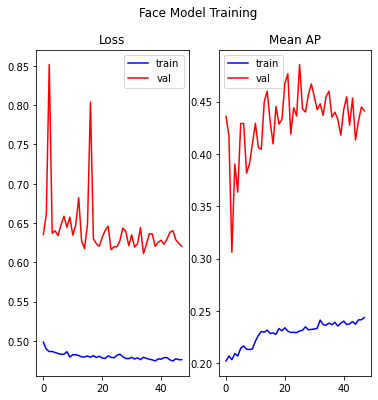

In [ ]:
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (6, 6))
f.suptitle('Face Model Training')
ax1.plot(range(0,len(train_loss)), train_loss, color='Blue')
ax1.plot(range(0,len(val_loss)), val_loss, color='Red')
ax2.plot(range(0,len(train_map)), train_map, color='Blue')
ax2.plot(range(0,len(val_map)), val_map, color='Red')
ax1.legend(['train','val'])
ax2.legend(['train','val'])
ax1.title.set_text('Loss')
ax2.title.set_text('Mean AP')

Test with model of epoch 48

In [ ]:
Face_testDB = Emotic_MultiDB(root_dir='Emotic_MultiDB',
                            annotation_dir='Annotations',
                            mode='test',
                            modality='face',
                            modals_dirs=modal_dirs,
                            categories=original_cats,
                            transform=transforms.Compose([Rescale(256,256,56),
                                                           RandomCrop(224,224,48),
                                                           ToTensor()])
                            )
Face_testDB.relabeled(newlabeles)
print('{} samples in pose val db'.format(len(Face_testDB)))

6998 samples in pose val db


In [ ]:
faceMAP = eval(Face_shortVGG, Face_testDB, 32, None, collate=collate, modal='face',
               device=device, debug_mode=True, tqdm=tqdm)


AveragePrecision: [0.79798746 0.578185   0.15859652 0.19992724 0.10821054 0.24625792
 0.1506007  0.8575001 ] |8| mAP: 0.38715818524360657


In [ ]:
testSampler = get_weighted_random_sampler(mode='test')

[0.00018584 0.00136426 0.0030303  0.00632911 0.01204819 0.00520833
 0.0625     0.00952381]
[5381  733  330  158   83  192   16  105]
0.00018583906337112061 0.00018583906337112061
torch.Size([6998])


In [ ]:
# Test using sampler in test set
faceMAP = eval(Face_shortVGG, Face_testDB, 32, testSampler, collate=collate, modal='face',
               device=device, debug_mode=True, tqdm=tqdm)


AveragePrecision: [0.13956131 0.21455607 0.16693756 0.24130899 0.24270894 0.41723418
 0.59736854 0.85019   ] |8| mAP: 0.3587331771850586


In [ ]:
del Face_shortVGG, Face_trainDB, Face_valDB, Face_testDB

### Training & Testing Body model

In [ ]:
from multimodalDLforER.utils.dataset import my_collate as collate
from multimodalDLforER.utils.traineval import train_step, eval

from torch.optim import Adam
from tqdm.notebook import tqdm

In [ ]:
bodyloss = nn.BCEWithLogitsLoss()
body_opt = Adam(Body_model.parameters(), lr=0.001, weight_decay=5e-4)

In [ ]:
trainSampler = get_weighted_random_sampler()

[0.00010166 0.00048309 0.00171233 0.00166945 0.00205339 0.00058241
 0.00429185 0.00013972]
[9837 2070  584  599  487 1717  233 7157]
0.001669449081803005 0.0004830917874396135
torch.Size([22684])


In [ ]:
valSampler = get_weighted_random_sampler(mode='val')

[3.54107649e-04 5.64971751e-03 8.54700855e-03 2.50000000e-02
 2.63157895e-02 4.34782609e-02 3.33333333e-01 1.00000000e+00]
[2824  177  117   40   38   23    3    1]
0.008547008547008548 0.0003541076487252125
torch.Size([3223])


In [ ]:
epoch_start = 0
last_epoch = 24
train_loss = [0] * (last_epoch-epoch_start)
val_loss = [0] * (last_epoch-epoch_start)
train_map = [0] * (last_epoch-epoch_start)
val_map = [0] * (last_epoch-epoch_start)
maxacc = -1
step_val = None
step_save = 4
batch_sz = 32

In [ ]:
for ep in range(epoch_start, last_epoch):
  maxacc = train_step(Model=Body_model, dataset_t=Body_trainDB,
                      dataset_v=Body_valDB, bsz=batch_sz,
                      Loss=bodyloss, optimizer=body_opt,
                      collate=collate, epoch=ep,
                      tsampler=trainSampler, vsampler=valSampler,
                      last_epoch=last_epoch, modal='body',
                      device=device, debug_mode=True,
                      tqdm=tqdm, train_loss=train_loss,
                      train_map=train_map, val_loss=val_loss,
                      val_map=val_map, maxacc=maxacc,
                      step2val=step_val, step2save=step_save,
                      checkpointdir='Checkpoints', model_name='bodyabn')
  print('  ////////////////////////////////////////////////////////////////')


AveragePrecision: [0.13086215 0.19862528 0.14067689 0.16642828 0.20534118 0.22820589
 0.28847063 0.47655615] |8| mAP: 0.2293958067893982



AveragePrecision: [0.10979843 0.22087234 0.20527528 0.2571945  0.29705095 0.48880473
 0.44142005 0.92500895] |8| mAP: 0.368178129196167
- Mean training loss: 0.9824 ; epoch 1
- Mean validation loss: 1.3349 ; epoch 1
- Mean training mAP: 0.2294 ; epoch 1
- Mean validation mAP: 0.3682 ; epoch 1
Model Checkpoints/bodyabn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.13018572 0.19385302 0.1339285  0.18065444 0.20476869 0.2251605
 0.29124168 0.4901864 ] |8| mAP: 0.23124738037586212



AveragePrecision: [0.19220169 0.32562658 0.17562327 0.29328302 0.29067    0.47471413
 0.39999104 0.92684805] |8| mAP: 0.3848697245121002
- Mean training loss: 0.9457 ; epoch 2
- Mean validation loss: 1.2517 ; epoch 2
- Mean training mAP: 0.2312 ; epoch 2
- Mean validation mAP: 0.3849 ; epoch 2
Model Checkpoints/bodyabn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.14007567 0.2145428  0.14657898 0.18333408 0.21485077 0.24259607
 0.30944547 0.48697233] |8| mAP: 0.24229952692985535



AveragePrecision: [0.15108956 0.32661188 0.19912978 0.33710945 0.42805028 0.46218118
 0.52823323 0.9583734 ] |8| mAP: 0.42384734749794006
- Mean training loss: 0.9433 ; epoch 3
- Mean validation loss: 1.3483 ; epoch 3
- Mean training mAP: 0.2423 ; epoch 3
- Mean validation mAP: 0.4238 ; epoch 3
Model Checkpoints/bodyabn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.14510588 0.2174378  0.14936057 0.18525286 0.22405006 0.23347838
 0.31735206 0.5069181 ] |8| mAP: 0.24736946821212769



AveragePrecision: [0.14791617 0.23946    0.3084745  0.30253828 0.35573378 0.5503915
 0.3611042  0.95511025] |8| mAP: 0.4025910794734955
- Mean training loss: 0.9402 ; epoch 4
- Mean validation loss: 1.2814 ; epoch 4
- Mean training mAP: 0.2474 ; epoch 4
- Mean validation mAP: 0.4026 ; epoch 4
Model Checkpoints/bodyabn_best.pth saved
Model Checkpoints/bodyabn_last.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.13114426 0.21691513 0.14979953 0.17924659 0.20812543 0.23828535
 0.293453   0.48832607] |8| mAP: 0.23816192150115967



AveragePrecision: [0.21241826 0.32593596 0.2203598  0.28487673 0.37487805 0.63462484
 0.47970125 0.9278632 ] |8| mAP: 0.4325822591781616
- Mean training loss: 0.9429 ; epoch 5
- Mean validation loss: 1.2953 ; epoch 5
- Mean training mAP: 0.2382 ; epoch 5
- Mean validation mAP: 0.4326 ; epoch 5
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.14834611 0.22213653 0.15122049 0.18559217 0.20705594 0.23409612
 0.30791178 0.49375388] |8| mAP: 0.24376413226127625



AveragePrecision: [0.20002438 0.31721947 0.25952974 0.37809482 0.47253743 0.6501567
 0.40723845 0.95508075] |8| mAP: 0.45498523116111755
- Mean training loss: 0.9403 ; epoch 6
- Mean validation loss: 1.3246 ; epoch 6
- Mean training mAP: 0.2438 ; epoch 6
- Mean validation mAP: 0.4550 ; epoch 6
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.14881764 0.22421546 0.15176393 0.19125499 0.2132788  0.24717776
 0.33001813 0.50516534] |8| mAP: 0.2514615058898926



AveragePrecision: [0.2337335  0.3404015  0.25765884 0.34489864 0.4721552  0.62216085
 0.52748895 0.970589  ] |8| mAP: 0.47113579511642456
- Mean training loss: 0.9356 ; epoch 7
- Mean validation loss: 1.3000 ; epoch 7
- Mean training mAP: 0.2515 ; epoch 7
- Mean validation mAP: 0.4711 ; epoch 7
Model Checkpoints/bodyabn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.1475898  0.22689654 0.15000731 0.18064941 0.22371006 0.2436181
 0.3420375  0.50925314] |8| mAP: 0.25297021865844727



AveragePrecision: [0.26424378 0.40446815 0.2721736  0.3294339  0.48738348 0.56225187
 0.49727318 0.96865   ] |8| mAP: 0.47323477268218994
- Mean training loss: 0.9343 ; epoch 8
- Mean validation loss: 1.2898 ; epoch 8
- Mean training mAP: 0.2530 ; epoch 8
- Mean validation mAP: 0.4732 ; epoch 8
Model Checkpoints/bodyabn_best.pth saved
Model Checkpoints/bodyabn_last.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.14626552 0.23331444 0.14974193 0.18659396 0.22812673 0.25488806
 0.3469981  0.5081011 ] |8| mAP: 0.25675374269485474



AveragePrecision: [0.20227182 0.32170162 0.25662136 0.30768818 0.404855   0.5485617
 0.4554398  0.96277314] |8| mAP: 0.4324890971183777
- Mean training loss: 0.9343 ; epoch 9
- Mean validation loss: 1.2700 ; epoch 9
- Mean training mAP: 0.2568 ; epoch 9
- Mean validation mAP: 0.4325 ; epoch 9
Model Checkpoints/bodyabn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.14291102 0.23226772 0.15096387 0.19470713 0.22237363 0.24894312
 0.33045417 0.5130149 ] |8| mAP: 0.25445443391799927



AveragePrecision: [0.27426445 0.35386565 0.23550697 0.3215355  0.4669     0.5869117
 0.549685   0.9529268 ] |8| mAP: 0.4676995277404785
- Mean training loss: 0.9345 ; epoch 10
- Mean validation loss: 1.2557 ; epoch 10
- Mean training mAP: 0.2545 ; epoch 10
- Mean validation mAP: 0.4677 ; epoch 10
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.1472542  0.23095968 0.14476092 0.1835182  0.21399686 0.24739072
 0.35499492 0.5196413 ] |8| mAP: 0.25531458854675293



AveragePrecision: [0.26725942 0.3392104  0.29119036 0.33253872 0.5100586  0.5257364
 0.49091065 0.969928  ] |8| mAP: 0.46585404872894287
- Mean training loss: 0.9325 ; epoch 11
- Mean validation loss: 1.3020 ; epoch 11
- Mean training mAP: 0.2553 ; epoch 11
- Mean validation mAP: 0.4659 ; epoch 11
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.14600348 0.23762941 0.14754146 0.18194447 0.22344065 0.252327
 0.35655007 0.5271508 ] |8| mAP: 0.259073406457901



AveragePrecision: [0.2698799  0.36534768 0.26127812 0.34285247 0.44370317 0.5641652
 0.4698728  0.97089386] |8| mAP: 0.46099916100502014
- Mean training loss: 0.9316 ; epoch 12
- Mean validation loss: 1.2867 ; epoch 12
- Mean training mAP: 0.2591 ; epoch 12
- Mean validation mAP: 0.4610 ; epoch 12
Model Checkpoints/bodyabn_best.pth saved
Model Checkpoints/bodyabn_last.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.150038   0.2309759  0.1473383  0.19518362 0.22461452 0.24874327
 0.33885005 0.5114218 ] |8| mAP: 0.2558956742286682



AveragePrecision: [0.23412058 0.34021538 0.2665289  0.3525965  0.5159646  0.623427
 0.52044046 0.97284883] |8| mAP: 0.4782677888870239
- Mean training loss: 0.9338 ; epoch 13
- Mean validation loss: 1.2790 ; epoch 13
- Mean training mAP: 0.2559 ; epoch 13
- Mean validation mAP: 0.4783 ; epoch 13
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.14378    0.23974651 0.14973898 0.18877679 0.22549213 0.25725454
 0.35958725 0.523697  ] |8| mAP: 0.261009156703949



AveragePrecision: [0.27841577 0.34537694 0.2625657  0.2864812  0.38588145 0.6247539
 0.36679024 0.9570898 ] |8| mAP: 0.438419371843338
- Mean training loss: 0.9297 ; epoch 14
- Mean validation loss: 1.2779 ; epoch 14
- Mean training mAP: 0.2610 ; epoch 14
- Mean validation mAP: 0.4384 ; epoch 14
Model Checkpoints/bodyabn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.15196362 0.23978972 0.15247077 0.19387318 0.22985815 0.24176641
 0.34674177 0.5238593 ] |8| mAP: 0.2600403428077698



AveragePrecision: [0.2796937  0.3855078  0.263191   0.33140785 0.54411674 0.5482749
 0.54322964 0.96568394] |8| mAP: 0.4826381802558899
- Mean training loss: 0.9299 ; epoch 15
- Mean validation loss: 1.2539 ; epoch 15
- Mean training mAP: 0.2600 ; epoch 15
- Mean validation mAP: 0.4826 ; epoch 15
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.14724985 0.24377646 0.1542445  0.18459615 0.2231313  0.24563365
 0.3397553  0.51706403] |8| mAP: 0.2569314241409302



AveragePrecision: [0.18954065 0.34888706 0.19741252 0.29677755 0.32673928 0.6295754
 0.4560962  0.9238106 ] |8| mAP: 0.42110490798950195
- Mean training loss: 0.9304 ; epoch 16
- Mean validation loss: 1.3055 ; epoch 16
- Mean training mAP: 0.2569 ; epoch 16
- Mean validation mAP: 0.4211 ; epoch 16
Model Checkpoints/bodyabn_last.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.14225204 0.24135359 0.15490483 0.19416119 0.23014393 0.24686085
 0.33814508 0.5237907 ] |8| mAP: 0.2589515447616577



AveragePrecision: [0.26524365 0.4057154  0.25123206 0.28530264 0.42880476 0.5782287
 0.48265213 0.9514488 ] |8| mAP: 0.45607852935791016
- Mean training loss: 0.9327 ; epoch 17
- Mean validation loss: 1.2459 ; epoch 17
- Mean training mAP: 0.2590 ; epoch 17
- Mean validation mAP: 0.4561 ; epoch 17
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.15348214 0.23619695 0.1457885  0.18733233 0.2230082  0.25079203
 0.36119497 0.52012205] |8| mAP: 0.25973963737487793



AveragePrecision: [0.25203812 0.36163816 0.21457176 0.34351048 0.47541973 0.61671
 0.52205944 0.9652307 ] |8| mAP: 0.46889728307724
- Mean training loss: 0.9281 ; epoch 18
- Mean validation loss: 1.3065 ; epoch 18
- Mean training mAP: 0.2597 ; epoch 18
- Mean validation mAP: 0.4689 ; epoch 18
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.15537381 0.24542834 0.15394558 0.18289118 0.23587759 0.25202093
 0.34557664 0.5280681 ] |8| mAP: 0.26239776611328125



AveragePrecision: [0.278074   0.40319616 0.23638983 0.34213427 0.507136   0.62556934
 0.5146585  0.9689448 ] |8| mAP: 0.4845128655433655
- Mean training loss: 0.9333 ; epoch 19
- Mean validation loss: 1.2571 ; epoch 19
- Mean training mAP: 0.2624 ; epoch 19
- Mean validation mAP: 0.4845 ; epoch 19
Model Checkpoints/bodyabn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.1487381  0.2546519  0.15737762 0.18952249 0.21793862 0.25106364
 0.35125184 0.53138953] |8| mAP: 0.26274171471595764



AveragePrecision: [0.29708976 0.40094706 0.23902988 0.3164772  0.55098516 0.64348924
 0.48673517 0.9647758 ] |8| mAP: 0.48744115233421326
- Mean training loss: 0.9332 ; epoch 20
- Mean validation loss: 1.2719 ; epoch 20
- Mean training mAP: 0.2627 ; epoch 20
- Mean validation mAP: 0.4874 ; epoch 20
Model Checkpoints/bodyabn_best.pth saved
Model Checkpoints/bodyabn_last.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.14654239 0.24001357 0.15174212 0.19176857 0.23284546 0.25757575
 0.33603472 0.5260211 ] |8| mAP: 0.26031798124313354



AveragePrecision: [0.20594028 0.3595153  0.2940627  0.2715159  0.52838296 0.49903777
 0.48924753 0.9558395 ] |8| mAP: 0.45044276118278503
- Mean training loss: 0.9285 ; epoch 21
- Mean validation loss: 1.3230 ; epoch 21
- Mean training mAP: 0.2603 ; epoch 21
- Mean validation mAP: 0.4504 ; epoch 21
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.15024658 0.2512171  0.15504222 0.17617029 0.2447699  0.2615366
 0.35864413 0.5358654 ] |8| mAP: 0.2666865289211273



AveragePrecision: [0.25276724 0.33869714 0.3179447  0.27446583 0.5401355  0.5461165
 0.47253934 0.9756479 ] |8| mAP: 0.4647892713546753
- Mean training loss: 0.9263 ; epoch 22
- Mean validation loss: 1.2923 ; epoch 22
- Mean training mAP: 0.2667 ; epoch 22
- Mean validation mAP: 0.4648 ; epoch 22
Model Checkpoints/bodyabn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.15284596 0.25623763 0.16225706 0.18932754 0.23686323 0.25336805
 0.3554076  0.53384817] |8| mAP: 0.26751941442489624



AveragePrecision: [0.25427946 0.36249104 0.24618468 0.35423037 0.53229195 0.6400391
 0.53726816 0.97875327] |8| mAP: 0.48819226026535034
- Mean training loss: 0.9319 ; epoch 23
- Mean validation loss: 1.2449 ; epoch 23
- Mean training mAP: 0.2675 ; epoch 23
- Mean validation mAP: 0.4882 ; epoch 23
Model Checkpoints/bodyabn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.15272686 0.24312791 0.1493146  0.18433322 0.22851105 0.25751945
 0.36544716 0.52557784] |8| mAP: 0.2633197605609894



AveragePrecision: [0.2724299  0.3930522  0.2770929  0.3318002  0.52171135 0.62433493
 0.5136187  0.9629114 ] |8| mAP: 0.4871189296245575
- Mean training loss: 0.9250 ; epoch 24
- Mean validation loss: 1.2938 ; epoch 24
- Mean training mAP: 0.2633 ; epoch 24
- Mean validation mAP: 0.4871 ; epoch 24
Model Checkpoints/bodyabn_last.pth saved
  ////////////////////////////////////////////////////////////////


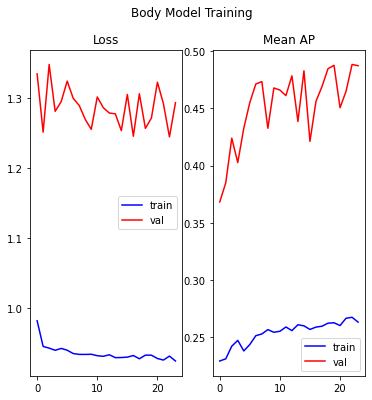

In [ ]:
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (6, 6))
f.suptitle('Body Model Training')
ax1.plot(range(0,len(train_loss)), train_loss, color='Blue')
ax1.plot(range(0,len(val_loss)), val_loss, color='Red')
ax2.plot(range(0,len(train_map)), train_map, color='Blue')
ax2.plot(range(0,len(val_map)), val_map, color='Red')
ax1.legend(['train','val'])
ax2.legend(['train','val'])
ax1.title.set_text('Loss')
ax2.title.set_text('Mean AP')

Test (model of epoch 24)

In [ ]:
Body_testDB = Emotic_MultiDB(root_dir='Emotic_MultiDB',
                            annotation_dir='Annotations',
                            mode='test',
                            modality='body',
                            modals_dirs=modal_dirs,
                            categories=original_cats,
                            transform=transforms.Compose([Rescale(256,256,56),
                                                           RandomCrop(224,224,48),
                                                           ToTensor()])
                            )
Body_testDB.relabeled(newlabeles)
print('{} samples in pose val db'.format(len(Body_testDB)))

6998 samples in pose val db


In [ ]:
testSampler = get_weighted_random_sampler(mode='test')

[0.00018584 0.00136426 0.0030303  0.00632911 0.01204819 0.00520833
 0.0625     0.00952381]
[5381  733  330  158   83  192   16  105]
0.00018583906337112061 0.00018583906337112061
torch.Size([6998])


In [ ]:
bodyMAP = eval(Body_model, Body_testDB, 32, testSampler, collate=collate, modal='body',
               device=device, debug_mode=True, tqdm=tqdm)

bodyMAP = eval(Body_model, Body_testDB, 32, None, collate=collate, modal='body',
               device=device, debug_mode=True, tqdm=tqdm)


AveragePrecision: [0.20260596 0.37184674 0.18612844 0.25652084 0.30046663 0.4092957
 0.4981137  0.87883085] |8| mAP: 0.38797610998153687



AveragePrecision: [0.812839   0.7143367  0.1729211  0.23035756 0.14852864 0.3033509
 0.13589565 0.88460404] |8| mAP: 0.4253541827201843


In [ ]:
del Body_model, Body_trainDB, Body_valDB, Body_testDB

### Training & Testing Context model

In [ ]:
from multimodalDLforER.utils.dataset import my_collate as collate
from multimodalDLforER.utils.traineval import train_step, eval

from torch.optim import Adam
from tqdm.notebook import tqdm

In [ ]:
contextloss = nn.BCEWithLogitsLoss()
context_opt = Adam(Context_model.parameters(), lr=0.001, weight_decay=5e-4)

In [ ]:
trainSampler = get_weighted_random_sampler()

[0.00010166 0.00048309 0.00171233 0.00166945 0.00205339 0.00058241
 0.00429185 0.00013972]
[9837 2070  584  599  487 1717  233 7157]
0.001669449081803005 0.0004830917874396135
torch.Size([22684])


In [ ]:
valSampler = get_weighted_random_sampler(mode='val')

[3.54107649e-04 5.64971751e-03 8.54700855e-03 2.50000000e-02
 2.63157895e-02 4.34782609e-02 3.33333333e-01 1.00000000e+00]
[2824  177  117   40   38   23    3    1]
0.008547008547008548 0.0003541076487252125
torch.Size([3223])


In [ ]:
epoch_start = 0
last_epoch = 24
train_loss = [0] * (last_epoch-epoch_start)
val_loss = [0] * (last_epoch-epoch_start)
train_map = [0] * (last_epoch-epoch_start)
val_map = [0] * (last_epoch-epoch_start)
maxacc = -1
step_val = None
step_save = 4
batch_sz = 32

In [ ]:
for ep in range(epoch_start, last_epoch):
  maxacc = train_step(Model=Context_model, dataset_t=Context_trainDB,
                      dataset_v=Context_valDB,bsz=batch_sz,
                      Loss=contextloss, optimizer=context_opt,
                      collate=collate, epoch=ep,
                      tsampler=trainSampler, vsampler=valSampler,
                      last_epoch=last_epoch, modal='context',
                      device=device, debug_mode=True,
                      tqdm=tqdm, train_loss=train_loss,
                      train_map=train_map, val_loss=val_loss,
                      val_map=val_map, maxacc=maxacc,
                      step2val=step_val, step2save=step_save,
                      checkpointdir='Checkpoints', model_name='contextabn')
  print('  ////////////////////////////////////////////////////////////////')


AveragePrecision: [0.12684396 0.17531541 0.13599694 0.16517472 0.19682129 0.23166834
 0.26562724 0.4744339 ] |8| mAP: 0.2214852273464203



AveragePrecision: [0.1158842  0.2099422  0.21507004 0.30223686 0.41662893 0.6694993
 0.58413297 0.8867119 ] |8| mAP: 0.42501330375671387
- Mean training loss: 1.0273 ; epoch 1
- Mean validation loss: 1.3026 ; epoch 1
- Mean training mAP: 0.2215 ; epoch 1
- Mean validation mAP: 0.4250 ; epoch 1
Model Checkpoints/contextabn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.12874418 0.17706893 0.13569431 0.1576193  0.21565892 0.22736607
 0.2792215  0.47826704] |8| mAP: 0.22495505213737488



AveragePrecision: [0.13914026 0.26082206 0.30815527 0.34034374 0.5142269  0.58812386
 0.5506184  0.98070794] |8| mAP: 0.4602673053741455
- Mean training loss: 0.9469 ; epoch 2
- Mean validation loss: 1.2813 ; epoch 2
- Mean training mAP: 0.2250 ; epoch 2
- Mean validation mAP: 0.4603 ; epoch 2
Model Checkpoints/contextabn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.12751971 0.17408095 0.14103813 0.1651087  0.22535007 0.23075575
 0.30319843 0.47824603] |8| mAP: 0.23066222667694092



AveragePrecision: [0.20174852 0.28858033 0.33283612 0.34259942 0.5265284  0.43292302
 0.57012725 0.9852799 ] |8| mAP: 0.4600778818130493
- Mean training loss: 0.9422 ; epoch 3
- Mean validation loss: 1.2369 ; epoch 3
- Mean training mAP: 0.2307 ; epoch 3
- Mean validation mAP: 0.4601 ; epoch 3
Model Checkpoints/contextabn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.14459208 0.1997866  0.14689426 0.16940393 0.21057782 0.24443124
 0.32680312 0.49801907] |8| mAP: 0.24256350100040436



AveragePrecision: [0.24989846 0.3919001  0.29743922 0.345083   0.48006648 0.46464697
 0.56369096 0.96551514] |8| mAP: 0.4697800278663635
- Mean training loss: 0.9407 ; epoch 4
- Mean validation loss: 1.2543 ; epoch 4
- Mean training mAP: 0.2426 ; epoch 4
- Mean validation mAP: 0.4698 ; epoch 4
Model Checkpoints/contextabn_best.pth saved
Model Checkpoints/contextabn_last.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.15045916 0.19682704 0.163527   0.18001944 0.22328484 0.24763209
 0.31114173 0.48977724] |8| mAP: 0.24533355236053467



AveragePrecision: [0.18025227 0.27742442 0.2859142  0.33602354 0.4428282  0.42120367
 0.5318398  0.94848764] |8| mAP: 0.4279967248439789
- Mean training loss: 0.9414 ; epoch 5
- Mean validation loss: 1.2770 ; epoch 5
- Mean training mAP: 0.2453 ; epoch 5
- Mean validation mAP: 0.4280 ; epoch 5
Model Checkpoints/contextabn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.14721762 0.20821181 0.15132326 0.1764843  0.2318046  0.2641327
 0.31377727 0.50166225] |8| mAP: 0.24932672083377838



AveragePrecision: [0.22497529 0.337416   0.25603396 0.26304284 0.4857711  0.50859016
 0.4234819  0.9721086 ] |8| mAP: 0.4339274764060974
- Mean training loss: 0.9369 ; epoch 6
- Mean validation loss: 1.2709 ; epoch 6
- Mean training mAP: 0.2493 ; epoch 6
- Mean validation mAP: 0.4339 ; epoch 6
Model Checkpoints/contextabn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.15202056 0.2084554  0.15194838 0.17925006 0.23209609 0.25175795
 0.3346062  0.49582312] |8| mAP: 0.2507447302341461



AveragePrecision: [0.25778374 0.3750758  0.2747465  0.2541519  0.48002526 0.48308468
 0.56312674 0.9502957 ] |8| mAP: 0.4547863006591797
- Mean training loss: 0.9339 ; epoch 7
- Mean validation loss: 1.2854 ; epoch 7
- Mean training mAP: 0.2507 ; epoch 7
- Mean validation mAP: 0.4548 ; epoch 7
Model Checkpoints/contextabn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.14142354 0.2103297  0.15556161 0.17311113 0.23844916 0.2557856
 0.34403256 0.5045495 ] |8| mAP: 0.25290536880493164



AveragePrecision: [0.24227041 0.43420056 0.19011104 0.18918633 0.4574632  0.43031415
 0.46105653 0.97866297] |8| mAP: 0.42290812730789185
- Mean training loss: 0.9335 ; epoch 8
- Mean validation loss: 1.3135 ; epoch 8
- Mean training mAP: 0.2529 ; epoch 8
- Mean validation mAP: 0.4229 ; epoch 8
Model Checkpoints/contextabn_best.pth saved
Model Checkpoints/contextabn_last.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.1470051  0.22355236 0.15051326 0.17223324 0.24097998 0.25923562
 0.34115368 0.51022243] |8| mAP: 0.25561195611953735



AveragePrecision: [0.23506369 0.39123034 0.24298933 0.19374155 0.5340066  0.42401934
 0.5576702  0.966574  ] |8| mAP: 0.44316190481185913
- Mean training loss: 0.9311 ; epoch 9
- Mean validation loss: 1.2716 ; epoch 9
- Mean training mAP: 0.2556 ; epoch 9
- Mean validation mAP: 0.4432 ; epoch 9
Model Checkpoints/contextabn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.14954548 0.23488288 0.15044525 0.17133015 0.24252029 0.26294827
 0.3357617  0.5028921 ] |8| mAP: 0.2562907636165619



AveragePrecision: [0.25335628 0.38467616 0.31890622 0.2789737  0.58876884 0.39584446
 0.5964969  0.98466986] |8| mAP: 0.47521156072616577
- Mean training loss: 0.9297 ; epoch 10
- Mean validation loss: 1.2443 ; epoch 10
- Mean training mAP: 0.2563 ; epoch 10
- Mean validation mAP: 0.4752 ; epoch 10
Model Checkpoints/contextabn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.15373528 0.24148056 0.15536997 0.18084101 0.24717122 0.26380873
 0.3537284  0.5204893 ] |8| mAP: 0.26457804441452026



AveragePrecision: [0.31495005 0.40639016 0.32197148 0.21811591 0.54209805 0.44082236
 0.5592045  0.97602177] |8| mAP: 0.4724467992782593
- Mean training loss: 0.9279 ; epoch 11
- Mean validation loss: 1.2694 ; epoch 11
- Mean training mAP: 0.2646 ; epoch 11
- Mean validation mAP: 0.4724 ; epoch 11
Model Checkpoints/contextabn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.15274274 0.23538168 0.15510495 0.18231139 0.24498023 0.26140106
 0.3487696  0.5189425 ] |8| mAP: 0.2624542713165283



AveragePrecision: [0.20412083 0.33530068 0.32630178 0.32928964 0.5176616  0.45014215
 0.4966715  0.98152137] |8| mAP: 0.45512616634368896
- Mean training loss: 0.9306 ; epoch 12
- Mean validation loss: 1.2835 ; epoch 12
- Mean training mAP: 0.2625 ; epoch 12
- Mean validation mAP: 0.4551 ; epoch 12
Model Checkpoints/contextabn_last.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.15346788 0.23644419 0.16479884 0.18375364 0.24152677 0.26768804
 0.3514539  0.5170145 ] |8| mAP: 0.26451846957206726



AveragePrecision: [0.13331124 0.23495479 0.29773214 0.33150378 0.506312   0.629543
 0.5736386  0.97795033] |8| mAP: 0.460618257522583
- Mean training loss: 0.9292 ; epoch 13
- Mean validation loss: 1.2701 ; epoch 13
- Mean training mAP: 0.2645 ; epoch 13
- Mean validation mAP: 0.4606 ; epoch 13
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.16143736 0.23230669 0.15796973 0.18447085 0.24700174 0.2606923
 0.3637398  0.5119566 ] |8| mAP: 0.2649468779563904



AveragePrecision: [0.22191405 0.37995595 0.3267422  0.26877066 0.56704384 0.40179852
 0.551402   0.9807437 ] |8| mAP: 0.46229636669158936
- Mean training loss: 0.9317 ; epoch 14
- Mean validation loss: 1.2689 ; epoch 14
- Mean training mAP: 0.2649 ; epoch 14
- Mean validation mAP: 0.4623 ; epoch 14
Model Checkpoints/contextabn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.15619788 0.24444884 0.1644493  0.18279873 0.24878211 0.270386
 0.35281885 0.5194599 ] |8| mAP: 0.26741769909858704



AveragePrecision: [0.21188498 0.32683232 0.33128345 0.2771261  0.4959709  0.43906203
 0.55074424 0.9732178 ] |8| mAP: 0.4507651925086975
- Mean training loss: 0.9316 ; epoch 15
- Mean validation loss: 1.2624 ; epoch 15
- Mean training mAP: 0.2674 ; epoch 15
- Mean validation mAP: 0.4508 ; epoch 15
Model Checkpoints/contextabn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.15981172 0.24808662 0.15557887 0.17182015 0.23488738 0.26686484
 0.38034505 0.5244032 ] |8| mAP: 0.2677247226238251



AveragePrecision: [0.24963316 0.37385523 0.333904   0.3454613  0.5602189  0.44464064
 0.59340924 0.9801495 ] |8| mAP: 0.4851589798927307
- Mean training loss: 0.9252 ; epoch 16
- Mean validation loss: 1.2525 ; epoch 16
- Mean training mAP: 0.2677 ; epoch 16
- Mean validation mAP: 0.4852 ; epoch 16
Model Checkpoints/contextabn_best.pth saved
Model Checkpoints/contextabn_last.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.15357494 0.25375628 0.15584712 0.17699724 0.25146535 0.2701129
 0.37583664 0.5290146 ] |8| mAP: 0.2708256244659424



AveragePrecision: [0.21235543 0.3554644  0.31735632 0.38736868 0.5410842  0.43192354
 0.5518883  0.9789543 ] |8| mAP: 0.47204938530921936
- Mean training loss: 0.9256 ; epoch 17
- Mean validation loss: 1.2705 ; epoch 17
- Mean training mAP: 0.2708 ; epoch 17
- Mean validation mAP: 0.4720 ; epoch 17
Model Checkpoints/contextabn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.15591432 0.24621668 0.14797746 0.18179727 0.2473332  0.2661074
 0.37435693 0.52043134] |8| mAP: 0.2675168216228485



AveragePrecision: [0.27737153 0.3660191  0.2884456  0.3126077  0.5606314  0.40145355
 0.5931329  0.9876583 ] |8| mAP: 0.4734150171279907
- Mean training loss: 0.9243 ; epoch 18
- Mean validation loss: 1.2373 ; epoch 18
- Mean training mAP: 0.2675 ; epoch 18
- Mean validation mAP: 0.4734 ; epoch 18
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.16138332 0.24757016 0.15431325 0.18228249 0.25035155 0.27150923
 0.3697271  0.52443165] |8| mAP: 0.2701960802078247



AveragePrecision: [0.27921233 0.4068633  0.30276802 0.25165275 0.5479741  0.39720193
 0.58043915 0.9823408 ] |8| mAP: 0.46855655312538147
- Mean training loss: 0.9257 ; epoch 19
- Mean validation loss: 1.2396 ; epoch 19
- Mean training mAP: 0.2702 ; epoch 19
- Mean validation mAP: 0.4686 ; epoch 19
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.15798663 0.2444293  0.15397136 0.18275292 0.24385157 0.2705981
 0.3700681  0.52234787] |8| mAP: 0.2682507336139679



AveragePrecision: [0.30992675 0.3872385  0.30253088 0.2269417  0.51341486 0.39857388
 0.5825779  0.9763876 ] |8| mAP: 0.46219900250434875
- Mean training loss: 0.9284 ; epoch 20
- Mean validation loss: 1.2382 ; epoch 20
- Mean training mAP: 0.2683 ; epoch 20
- Mean validation mAP: 0.4622 ; epoch 20
Model Checkpoints/contextabn_last.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.15688115 0.25001812 0.15502185 0.18449982 0.25311166 0.26881883
 0.36507323 0.53800595] |8| mAP: 0.27142882347106934



AveragePrecision: [0.26963264 0.3906588  0.30984432 0.24803035 0.48346278 0.42230558
 0.55000293 0.9687528 ] |8| mAP: 0.4553362727165222
- Mean training loss: 0.9227 ; epoch 21
- Mean validation loss: 1.2542 ; epoch 21
- Mean training mAP: 0.2714 ; epoch 21
- Mean validation mAP: 0.4553 ; epoch 21
Model Checkpoints/contextabn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.16319548 0.24399167 0.1555654  0.18544134 0.23909469 0.25976032
 0.3628683  0.5293237 ] |8| mAP: 0.26740512251853943



AveragePrecision: [0.24439535 0.3742783  0.2671304  0.24853712 0.49675214 0.4807567
 0.54737115 0.96746606] |8| mAP: 0.4533359110355377
- Mean training loss: 0.9241 ; epoch 22
- Mean validation loss: 1.2536 ; epoch 22
- Mean training mAP: 0.2674 ; epoch 22
- Mean validation mAP: 0.4533 ; epoch 22
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.15608484 0.2622719  0.15868355 0.19194521 0.24667767 0.27685547
 0.37082934 0.5301177 ] |8| mAP: 0.2741832137107849



AveragePrecision: [0.25996992 0.41523343 0.34764236 0.22451845 0.59285414 0.40521204
 0.5706626  0.9823821 ] |8| mAP: 0.4748094081878662
- Mean training loss: 0.9267 ; epoch 23
- Mean validation loss: 1.2666 ; epoch 23
- Mean training mAP: 0.2742 ; epoch 23
- Mean validation mAP: 0.4748 ; epoch 23
Model Checkpoints/contextabn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.1670687  0.24861193 0.15985309 0.18491289 0.24103223 0.2709193
 0.38489547 0.5272446 ] |8| mAP: 0.27306726574897766



AveragePrecision: [0.2828545  0.38658345 0.3255578  0.26191905 0.5785547  0.48536026
 0.5219371  0.98443437] |8| mAP: 0.47840017080307007
- Mean training loss: 0.9264 ; epoch 24
- Mean validation loss: 1.2620 ; epoch 24
- Mean training mAP: 0.2731 ; epoch 24
- Mean validation mAP: 0.4784 ; epoch 24
Model Checkpoints/contextabn_last.pth saved
  ////////////////////////////////////////////////////////////////


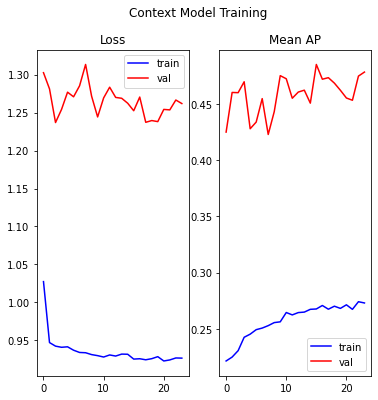

In [ ]:
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (6, 6))
f.suptitle('Context Model Training')
ax1.plot(range(0,len(train_loss)), train_loss, color='Blue')
ax1.plot(range(0,len(val_loss)), val_loss, color='Red')
ax2.plot(range(0,len(train_map)), train_map, color='Blue')
ax2.plot(range(0,len(val_map)), val_map, color='Red')
ax1.legend(['train','val'])
ax2.legend(['train','val'])
ax1.title.set_text('Loss')
ax2.title.set_text('Mean AP')

Test with the model of epochs 24 and 23

In [ ]:
Context_testDB = Emotic_MultiDB(root_dir='Emotic_MultiDB',
                            annotation_dir='Annotations',
                            mode='test',
                            modality='context',
                            modals_dirs=modal_dirs,
                            categories=original_cats,
                            transform=transforms.Compose([Rescale(256,256,56),
                                                           RandomCrop(224,224,48),
                                                           ToTensor()])
                            )
Context_testDB.relabeled(newlabeles)
print('{} samples in pose val db'.format(len(Context_testDB)))

6998 samples in pose val db


In [ ]:
testSampler = get_weighted_random_sampler(mode='test')

[0.00018584 0.00136426 0.0030303  0.00632911 0.01204819 0.00520833
 0.0625     0.00952381]
[5381  733  330  158   83  192   16  105]
0.00018583906337112061 0.00018583906337112061
torch.Size([6998])


In [ ]:
contexMAP = eval(Context_model, Context_testDB, 32, testSampler, collate=collate, modal='context',
               device=device, debug_mode=True, tqdm=tqdm)

contexMAP = eval(Context_model, Context_testDB, 32, None, collate=collate, modal='context',
               device=device, debug_mode=True, tqdm=tqdm)


AveragePrecision: [0.17984836 0.32095793 0.20158617 0.23057978 0.28357124 0.39405414
 0.5311324  0.8851999 ] |8| mAP: 0.37836623191833496



AveragePrecision: [0.8150216  0.7005913  0.17068648 0.2142999  0.13893366 0.3069586
 0.13500856 0.883555  ] |8| mAP: 0.42063188552856445


In [ ]:
dictlo = torch.load('/content/Checkpoints/contextabn_best.pth')

In [ ]:
Context_modelb = resnet18(num_classes=8)
Context_modelb.load_state_dict(dictlo['model_state_dict'])
Context_modelb = Context_modelb.to(device)
dictlo['epoch']

22

In [ ]:
contexMAP = eval(Context_modelb, Context_testDB, 32, testSampler, collate=collate, modal='context',
               device=device, debug_mode=True, tqdm=tqdm)

contexMAP = eval(Context_modelb, Context_testDB, 32, None, collate=collate, modal='context',
               device=device, debug_mode=True, tqdm=tqdm)


AveragePrecision: [0.20440102 0.35224843 0.18787357 0.23300533 0.28134722 0.40569714
 0.55908394 0.8882473 ] |8| mAP: 0.3889879882335663



AveragePrecision: [0.8147149  0.6928691  0.170575   0.22401164 0.14530937 0.31887847
 0.14113626 0.8772504 ] |8| mAP: 0.42309314012527466


In [ ]:
del Context_model, Context_modelb, Context_trainDB, Context_valDB, Context_testDB

### Training & Testing Posture model

In [ ]:
from multimodalDLforER.utils.dataset import my_collate as collate
from multimodalDLforER.utils.traineval import train_step, eval

from torch.optim import Adam
from tqdm.notebook import tqdm

In [ ]:
poseloss = nn.BCEWithLogitsLoss()
pose_opt = Adam(Pose_model.parameters(), lr=0.001, weight_decay=5e-4)

In [ ]:
epoch_start = 0
last_epoch = 32
train_loss = [0] * (last_epoch-epoch_start)
val_loss = [0] * (last_epoch-epoch_start)
train_map = [0] * (last_epoch-epoch_start)
val_map = [0] * (last_epoch-epoch_start)
maxacc = -1
step_val = None
step_save = 5
batch_sz = 32

In [ ]:
trainSampler = get_weighted_random_sampler()

[0.00010166 0.00048309 0.00171233 0.00166945 0.00205339 0.00058241
 0.00429185 0.00013972]
[9837 2070  584  599  487 1717  233 7157]
0.001669449081803005 0.0004830917874396135
torch.Size([22684])


In [ ]:
valSampler = get_weighted_random_sampler(mode='val')

[3.54107649e-04 5.64971751e-03 8.54700855e-03 2.50000000e-02
 2.63157895e-02 4.34782609e-02 3.33333333e-01 1.00000000e+00]
[2824  177  117   40   38   23    3    1]
0.008547008547008548 0.0003541076487252125
torch.Size([3223])


Training without sampler

In [ ]:
for ep in range(epoch_start, last_epoch):
  maxacc = train_step(Model=Pose_model, dataset_t=Pose_trainDB,
                      dataset_v=Pose_valDB, bsz=batch_sz,
                      Loss=poseloss, optimizer=pose_opt,
                      collate=collate, epoch=ep,
                      tsampler=None, vsampler=None,
                      last_epoch=last_epoch, modal='pose',
                      device=device, debug_mode=True,
                      tqdm=tqdm, train_loss=train_loss,
                      train_map=train_map, val_loss=val_loss,
                      val_map=val_map, maxacc=maxacc,
                      step2val=step_val, step2save=step_save,
                      checkpointdir='Checkpoints', model_name='posedgcnn')
  print('  ////////////////////////////////////////////////////////////////')


AveragePrecision: [0.44639468 0.26643282 0.03377052 0.05045786 0.05308221 0.12729391
 0.04211125 0.67818356] |8| mAP: 0.212215855717659



AveragePrecision: [0.87501085 0.82537436 0.21454823 0.23191002 0.17348409 0.4388399
 0.18522021 0.9852806 ] |8| mAP: 0.4912085235118866
- Mean training loss: 0.3932 ; epoch 1
- Mean validation loss: 0.7797 ; epoch 1
- Mean training mAP: 0.2122 ; epoch 1
- Mean validation mAP: 0.4912 ; epoch 1
Model Checkpoints/posedgcnn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.46793354 0.28673133 0.03687256 0.06076697 0.06348445 0.13736615
 0.06089461 0.6939477 ] |8| mAP: 0.22599966824054718



AveragePrecision: [0.87310493 0.82359004 0.21661162 0.23549859 0.18246312 0.45323086
 0.19272916 0.9839381 ] |8| mAP: 0.4951457977294922
- Mean training loss: 0.3515 ; epoch 2
- Mean validation loss: 0.7559 ; epoch 2
- Mean training mAP: 0.2260 ; epoch 2
- Mean validation mAP: 0.4951 ; epoch 2
Model Checkpoints/posedgcnn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.47645184 0.29314733 0.03957285 0.06025255 0.06949852 0.141713
 0.063518   0.698301  ] |8| mAP: 0.23030689358711243



AveragePrecision: [0.87953997 0.8248341  0.21002024 0.23608482 0.18030074 0.45472544
 0.21543169 0.9901704 ] |8| mAP: 0.49888843297958374
- Mean training loss: 0.3493 ; epoch 3
- Mean validation loss: 0.7168 ; epoch 3
- Mean training mAP: 0.2303 ; epoch 3
- Mean validation mAP: 0.4989 ; epoch 3
Model Checkpoints/posedgcnn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.4842078  0.29391432 0.03956252 0.06127363 0.07096022 0.14105654
 0.06335668 0.7006465 ] |8| mAP: 0.2318722903728485



AveragePrecision: [0.8727376  0.82292527 0.21211891 0.23801765 0.18250802 0.4140738
 0.1934012  0.98512477] |8| mAP: 0.49011337757110596
- Mean training loss: 0.3485 ; epoch 4
- Mean validation loss: 0.7137 ; epoch 4
- Mean training mAP: 0.2319 ; epoch 4
- Mean validation mAP: 0.4901 ; epoch 4
Model Checkpoints/posedgcnn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.47766393 0.29602805 0.04113895 0.06175273 0.06872104 0.14286378
 0.06691033 0.6990096 ] |8| mAP: 0.23176105320453644



AveragePrecision: [0.8635389  0.80720854 0.21183452 0.22473946 0.15293159 0.4452456
 0.20356132 0.9835595 ] |8| mAP: 0.48657745122909546
- Mean training loss: 0.3484 ; epoch 5
- Mean validation loss: 0.6938 ; epoch 5
- Mean training mAP: 0.2318 ; epoch 5
- Mean validation mAP: 0.4866 ; epoch 5
Model Checkpoints/posedgcnn_last.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.48057267 0.29606432 0.04308773 0.06572463 0.07090268 0.1445031
 0.06966324 0.69883865] |8| mAP: 0.23366960883140564



AveragePrecision: [0.8696445  0.78684205 0.20832603 0.23541379 0.18956958 0.44059154
 0.2057906  0.989117  ] |8| mAP: 0.4906618893146515
- Mean training loss: 0.3478 ; epoch 6
- Mean validation loss: 0.6998 ; epoch 6
- Mean training mAP: 0.2337 ; epoch 6
- Mean validation mAP: 0.4907 ; epoch 6
Model Checkpoints/posedgcnn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.48086146 0.30035484 0.04220839 0.0656384  0.07260273 0.14725715
 0.07026812 0.703778  ] |8| mAP: 0.23537114262580872



AveragePrecision: [0.8887058  0.81292677 0.22271141 0.23858099 0.19378243 0.45533314
 0.21754359 0.97939485] |8| mAP: 0.5011223554611206
- Mean training loss: 0.3471 ; epoch 7
- Mean validation loss: 0.6673 ; epoch 7
- Mean training mAP: 0.2354 ; epoch 7
- Mean validation mAP: 0.5011 ; epoch 7
Model Checkpoints/posedgcnn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.48165318 0.30033177 0.04543581 0.06961633 0.07661427 0.15038382
 0.07977945 0.70190245] |8| mAP: 0.2382146418094635



AveragePrecision: [0.9220492  0.8296443  0.22700815 0.24296801 0.19954811 0.4498276
 0.2179374  0.9880785 ] |8| mAP: 0.5096326470375061
- Mean training loss: 0.3464 ; epoch 8
- Mean validation loss: 0.6516 ; epoch 8
- Mean training mAP: 0.2382 ; epoch 8
- Mean validation mAP: 0.5096 ; epoch 8
Model Checkpoints/posedgcnn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.4832188  0.30554053 0.04818704 0.07131737 0.07843765 0.15538011
 0.08436088 0.70499504] |8| mAP: 0.24142968654632568



AveragePrecision: [0.903411   0.83142453 0.2300588  0.24487299 0.20187588 0.44736665
 0.2225006  0.98366034] |8| mAP: 0.508146345615387
- Mean training loss: 0.3455 ; epoch 9
- Mean validation loss: 0.6619 ; epoch 9
- Mean training mAP: 0.2414 ; epoch 9
- Mean validation mAP: 0.5081 ; epoch 9
Model Checkpoints/posedgcnn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.48914155 0.3087599  0.04956251 0.07113444 0.07877128 0.15741386
 0.08700343 0.7062865 ] |8| mAP: 0.2435091733932495



AveragePrecision: [0.9031578  0.8342505  0.23067401 0.2445631  0.18481159 0.4540089
 0.22486894 0.9868498 ] |8| mAP: 0.5078980922698975
- Mean training loss: 0.3449 ; epoch 10
- Mean validation loss: 0.6697 ; epoch 10
- Mean training mAP: 0.2435 ; epoch 10
- Mean validation mAP: 0.5079 ; epoch 10
Model Checkpoints/posedgcnn_best.pth saved
Model Checkpoints/posedgcnn_last.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.48498592 0.30921617 0.04964015 0.07145763 0.08008106 0.15829524
 0.09053993 0.71212035] |8| mAP: 0.24454206228256226



AveragePrecision: [0.8655579  0.8367073  0.22513683 0.24408291 0.20590682 0.4384814
 0.22730882 0.99013644] |8| mAP: 0.5041648149490356
- Mean training loss: 0.3445 ; epoch 11
- Mean validation loss: 0.6900 ; epoch 11
- Mean training mAP: 0.2445 ; epoch 11
- Mean validation mAP: 0.5042 ; epoch 11
Model Checkpoints/posedgcnn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.4896419  0.31142744 0.04943845 0.07273719 0.0822147  0.16306035
 0.08847215 0.71265733] |8| mAP: 0.24620619416236877



AveragePrecision: [0.8966807  0.8341367  0.22867908 0.24073851 0.20572105 0.43610922
 0.22392456 0.989087  ] |8| mAP: 0.5068845748901367
- Mean training loss: 0.3440 ; epoch 12
- Mean validation loss: 0.6973 ; epoch 12
- Mean training mAP: 0.2462 ; epoch 12
- Mean validation mAP: 0.5069 ; epoch 12
Model Checkpoints/posedgcnn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.4945348  0.31604657 0.05239144 0.07304306 0.0818352  0.16728124
 0.09014846 0.717382  ] |8| mAP: 0.24908284842967987



AveragePrecision: [0.88241786 0.8386836  0.22936903 0.24705745 0.20493536 0.448508
 0.2282766  0.98984075] |8| mAP: 0.5086360573768616
- Mean training loss: 0.3432 ; epoch 13
- Mean validation loss: 0.6992 ; epoch 13
- Mean training mAP: 0.2491 ; epoch 13
- Mean validation mAP: 0.5086 ; epoch 13
Model Checkpoints/posedgcnn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.49640357 0.3193269  0.05151105 0.0729459  0.08370081 0.16723219
 0.08670663 0.7199911 ] |8| mAP: 0.2497272789478302



AveragePrecision: [0.89373755 0.8396421  0.2326106  0.24430998 0.20428908 0.44827318
 0.2226144  0.99031794] |8| mAP: 0.5094743371009827
- Mean training loss: 0.3428 ; epoch 14
- Mean validation loss: 0.7014 ; epoch 14
- Mean training mAP: 0.2497 ; epoch 14
- Mean validation mAP: 0.5095 ; epoch 14
Model Checkpoints/posedgcnn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.49761075 0.31953976 0.05327953 0.07224331 0.08459176 0.16806634
 0.0934639  0.7237453 ] |8| mAP: 0.2515675723552704



AveragePrecision: [0.89490813 0.83872426 0.22807036 0.2391584  0.20013785 0.45234862
 0.2186749  0.98924655] |8| mAP: 0.5076586008071899
- Mean training loss: 0.3425 ; epoch 15
- Mean validation loss: 0.7011 ; epoch 15
- Mean training mAP: 0.2516 ; epoch 15
- Mean validation mAP: 0.5077 ; epoch 15
Model Checkpoints/posedgcnn_best.pth saved
Model Checkpoints/posedgcnn_last.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.4992526  0.32047564 0.05424049 0.07147896 0.08625127 0.169272
 0.09446844 0.7258154 ] |8| mAP: 0.25265684723854065



AveragePrecision: [0.90805876 0.8394627  0.23355389 0.23959152 0.19773349 0.45481458
 0.21542485 0.9890294 ] |8| mAP: 0.5097086429595947
- Mean training loss: 0.3422 ; epoch 16
- Mean validation loss: 0.7057 ; epoch 16
- Mean training mAP: 0.2527 ; epoch 16
- Mean validation mAP: 0.5097 ; epoch 16
Model Checkpoints/posedgcnn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.5015272  0.32150906 0.05397185 0.07363632 0.08679734 0.17098105
 0.09537942 0.7273482 ] |8| mAP: 0.25389382243156433



AveragePrecision: [0.91421914 0.8381002  0.22995411 0.24381055 0.19419329 0.45762655
 0.21880262 0.9894757 ] |8| mAP: 0.5107727646827698
- Mean training loss: 0.3419 ; epoch 17
- Mean validation loss: 0.7019 ; epoch 17
- Mean training mAP: 0.2539 ; epoch 17
- Mean validation mAP: 0.5108 ; epoch 17
Model Checkpoints/posedgcnn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.50353265 0.32208416 0.05613192 0.07349149 0.08747266 0.17280221
 0.09704235 0.72889054] |8| mAP: 0.2551810145378113



AveragePrecision: [0.9118564  0.83752435 0.22714625 0.24021041 0.19774814 0.4687677
 0.20802727 0.98644567] |8| mAP: 0.5097157955169678
- Mean training loss: 0.3416 ; epoch 18
- Mean validation loss: 0.7072 ; epoch 18
- Mean training mAP: 0.2552 ; epoch 18
- Mean validation mAP: 0.5097 ; epoch 18
Model Checkpoints/posedgcnn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.5060256  0.32242888 0.05698603 0.07262833 0.08900737 0.17424613
 0.09732471 0.7295635 ] |8| mAP: 0.25602632761001587



AveragePrecision: [0.9171826  0.83736527 0.2323163  0.23680437 0.19748764 0.46467236
 0.2092299  0.9865518 ] |8| mAP: 0.5102012753486633
- Mean training loss: 0.3415 ; epoch 19
- Mean validation loss: 0.7069 ; epoch 19
- Mean training mAP: 0.2560 ; epoch 19
- Mean validation mAP: 0.5102 ; epoch 19
Model Checkpoints/posedgcnn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.5062302  0.32366487 0.05761463 0.07423524 0.08737669 0.17632376
 0.10012399 0.73158807] |8| mAP: 0.2571446895599365



AveragePrecision: [0.9086899  0.8395145  0.23168871 0.23116376 0.198563   0.46892026
 0.21030892 0.98759365] |8| mAP: 0.5095553398132324
- Mean training loss: 0.3412 ; epoch 20
- Mean validation loss: 0.7103 ; epoch 20
- Mean training mAP: 0.2571 ; epoch 20
- Mean validation mAP: 0.5096 ; epoch 20
Model Checkpoints/posedgcnn_best.pth saved
Model Checkpoints/posedgcnn_last.pth saved
  ////////////////////////////////////////////////////////////////


KeyboardInterrupt: ignored

In [ ]:
epoch_start = 20
last_epoch = 32

In [ ]:
for ep in range(epoch_start, last_epoch):
  maxacc = train_step(Model=Pose_model, dataset_t=Pose_trainDB,
                      dataset_v=Pose_valDB, bsz=batch_sz,
                      Loss=poseloss, optimizer=pose_opt,
                      collate=collate, epoch=ep,
                      tsampler=None, vsampler=None,
                      last_epoch=last_epoch, modal='pose',
                      device=device, debug_mode=True,
                      tqdm=tqdm, train_loss=train_loss,
                      train_map=train_map, val_loss=val_loss,
                      val_map=val_map, maxacc=maxacc,
                      step2val=step_val, step2save=step_save,
                      checkpointdir='Checkpoints', model_name='posedgcnn')
  print('  ////////////////////////////////////////////////////////////////')


AveragePrecision: [0.5065213  0.3241489  0.05664262 0.07553479 0.08726153 0.17574358
 0.10034129 0.7313369 ] |8| mAP: 0.25719135999679565



AveragePrecision: [0.91019243 0.8434781  0.22596154 0.23966628 0.2100448  0.46084347
 0.22187996 0.9883896 ] |8| mAP: 0.5125570297241211
- Mean training loss: 0.3412 ; epoch 21
- Mean validation loss: 0.7136 ; epoch 21
- Mean training mAP: 0.2572 ; epoch 21
- Mean validation mAP: 0.5126 ; epoch 21
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.509523   0.32634252 0.05778455 0.07563251 0.08868615 0.17927043
 0.1043787  0.7322618 ] |8| mAP: 0.2592349648475647



AveragePrecision: [0.91453665 0.84594935 0.23207086 0.24087653 0.21085376 0.47170326
 0.21904501 0.9877876 ] |8| mAP: 0.5153529047966003
- Mean training loss: 0.3410 ; epoch 22
- Mean validation loss: 0.7136 ; epoch 22
- Mean training mAP: 0.2592 ; epoch 22
- Mean validation mAP: 0.5154 ; epoch 22
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.5099929  0.32720718 0.05930837 0.07522358 0.08822329 0.17949784
 0.10474527 0.73147124] |8| mAP: 0.2594587206840515



AveragePrecision: [0.9157413  0.84491956 0.23399365 0.2394316  0.20819513 0.46939653
 0.21413444 0.989013  ] |8| mAP: 0.5143531560897827
- Mean training loss: 0.3409 ; epoch 23
- Mean validation loss: 0.7127 ; epoch 23
- Mean training mAP: 0.2595 ; epoch 23
- Mean validation mAP: 0.5144 ; epoch 23
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.51017994 0.3282019  0.06004782 0.07462398 0.0901736  0.17934853
 0.10442632 0.7325215 ] |8| mAP: 0.2599404454231262



AveragePrecision: [0.9107959  0.84599704 0.23054457 0.24173874 0.20985326 0.46431974
 0.21563935 0.989638  ] |8| mAP: 0.5135658383369446
- Mean training loss: 0.3406 ; epoch 24
- Mean validation loss: 0.7113 ; epoch 24
- Mean training mAP: 0.2599 ; epoch 24
- Mean validation mAP: 0.5136 ; epoch 24
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.5124371  0.33003408 0.06091136 0.07643127 0.09234635 0.18214682
 0.10447274 0.7330264 ] |8| mAP: 0.2614757716655731



AveragePrecision: [0.915026   0.84553194 0.23714638 0.23306344 0.21736115 0.4654846
 0.22466944 0.98847705] |8| mAP: 0.515845000743866
- Mean training loss: 0.3404 ; epoch 25
- Mean validation loss: 0.7174 ; epoch 25
- Mean training mAP: 0.2615 ; epoch 25
- Mean validation mAP: 0.5158 ; epoch 25
Model Checkpoints/posedgcnn_last.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.5113178  0.32937208 0.06277018 0.07728021 0.09496468 0.18427029
 0.10687473 0.7331147 ] |8| mAP: 0.26249557733535767



AveragePrecision: [0.91666836 0.84828514 0.22466546 0.24190083 0.19214822 0.45699015
 0.20057426 0.98755014] |8| mAP: 0.5085978507995605
- Mean training loss: 0.3403 ; epoch 26
- Mean validation loss: 0.7068 ; epoch 26
- Mean training mAP: 0.2625 ; epoch 26
- Mean validation mAP: 0.5086 ; epoch 26
Model Checkpoints/posedgcnn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.5120866  0.32989147 0.06425419 0.07735747 0.09486456 0.18684836
 0.10557181 0.7341532 ] |8| mAP: 0.26312845945358276



AveragePrecision: [0.9207639  0.8454033  0.23640515 0.23977092 0.20326565 0.47813213
 0.21482362 0.9870163 ] |8| mAP: 0.5156975984573364
- Mean training loss: 0.3400 ; epoch 27
- Mean validation loss: 0.7028 ; epoch 27
- Mean training mAP: 0.2631 ; epoch 27
- Mean validation mAP: 0.5157 ; epoch 27
Model Checkpoints/posedgcnn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.5135093  0.33134955 0.06621678 0.07762693 0.09442665 0.18845014
 0.10753085 0.7336711 ] |8| mAP: 0.264097660779953



AveragePrecision: [0.91432935 0.8447666  0.22575882 0.23129134 0.17988925 0.47976282
 0.18952748 0.9846483 ] |8| mAP: 0.5062466859817505
- Mean training loss: 0.3399 ; epoch 28
- Mean validation loss: 0.6997 ; epoch 28
- Mean training mAP: 0.2641 ; epoch 28
- Mean validation mAP: 0.5062 ; epoch 28
Model Checkpoints/posedgcnn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.51270515 0.3322827  0.06785417 0.07824231 0.09744925 0.18958697
 0.10805967 0.73500055] |8| mAP: 0.2651475965976715



AveragePrecision: [0.9049594  0.83761966 0.23014942 0.22551553 0.18729779 0.47260353
 0.19144283 0.9849675 ] |8| mAP: 0.504319429397583
- Mean training loss: 0.3397 ; epoch 29
- Mean validation loss: 0.7024 ; epoch 29
- Mean training mAP: 0.2651 ; epoch 29
- Mean validation mAP: 0.5043 ; epoch 29
Model Checkpoints/posedgcnn_best.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.5148543  0.33140194 0.0653956  0.0771374  0.09683294 0.19140112
 0.10723928 0.73492086] |8| mAP: 0.2648979425430298



AveragePrecision: [0.9127141  0.8438161  0.22708064 0.23222707 0.20242743 0.47648895
 0.21137892 0.9861088 ] |8| mAP: 0.5115302801132202
- Mean training loss: 0.3396 ; epoch 30
- Mean validation loss: 0.7050 ; epoch 30
- Mean training mAP: 0.2649 ; epoch 30
- Mean validation mAP: 0.5115 ; epoch 30
Model Checkpoints/posedgcnn_last.pth saved
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.5155813  0.33124045 0.06431168 0.07669474 0.09765414 0.1937596
 0.10460371 0.73585796] |8| mAP: 0.26496294140815735



AveragePrecision: [0.9214566  0.843592   0.23380415 0.23619987 0.19348004 0.47170126
 0.20796552 0.98494107] |8| mAP: 0.511642575263977
- Mean training loss: 0.3394 ; epoch 31
- Mean validation loss: 0.7135 ; epoch 31
- Mean training mAP: 0.2650 ; epoch 31
- Mean validation mAP: 0.5116 ; epoch 31
  ////////////////////////////////////////////////////////////////



AveragePrecision: [0.514134   0.33152413 0.06643883 0.07940192 0.09763405 0.19252631
 0.10754151 0.73501474] |8| mAP: 0.2655269503593445



AveragePrecision: [0.9227683  0.8367554  0.22818604 0.23262276 0.19195211 0.46700338
 0.20763996 0.985773  ] |8| mAP: 0.5090876221656799
- Mean training loss: 0.3394 ; epoch 32
- Mean validation loss: 0.7208 ; epoch 32
- Mean training mAP: 0.2655 ; epoch 32
- Mean validation mAP: 0.5091 ; epoch 32
Model Checkpoints/posedgcnn_best.pth saved
Model Checkpoints/posedgcnn_last.pth saved
  ////////////////////////////////////////////////////////////////


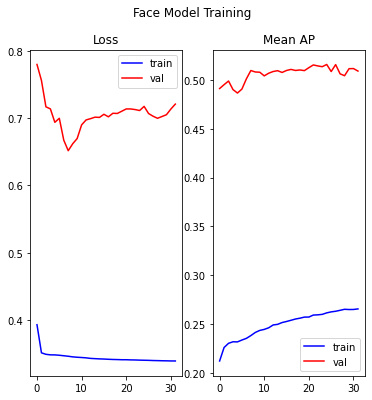

In [ ]:
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (6, 6))
f.suptitle('Face Model Training')
ax1.plot(range(0,len(train_loss)), train_loss, color='Blue')
ax1.plot(range(0,len(val_loss)), val_loss, color='Red')
ax2.plot(range(0,len(train_map)), train_map, color='Blue')
ax2.plot(range(0,len(val_map)), val_map, color='Red')
ax1.legend(['train','val'])
ax2.legend(['train','val'])
ax1.title.set_text('Loss')
ax2.title.set_text('Mean AP')

Sampler training stopped at epoch 16 and ruled out due to possible overfitting

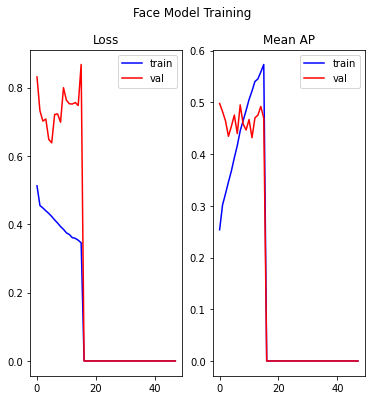

In [ ]:
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (6, 6))
f.suptitle('Face Model Training')
ax1.plot(range(0,len(train_loss)), train_loss, color='Blue')
ax1.plot(range(0,len(val_loss)), val_loss, color='Red')
ax2.plot(range(0,len(train_map)), train_map, color='Blue')
ax2.plot(range(0,len(val_map)), val_map, color='Red')
ax1.legend(['train','val'])
ax2.legend(['train','val'])
ax1.title.set_text('Loss')
ax2.title.set_text('Mean AP')

Test with models of epochs 32 and 20

In [ ]:
Pose_testDB = Emotic_MultiDB(root_dir='Emotic_MultiDB',
                            annotation_dir='Annotations',
                            mode='test',
                            modality='pose',
                            takeone=True,
                            modals_dirs=modal_dirs,
                            categories=original_cats,
                            transform=transforms.Compose([Rescale(256,256,60),
                                                           RandomCrop(224,224,48),
                                                           ToTensor()])
                            )
Pose_testDB.relabeled(newlabeles)
print('{} samples in pose val db'.format(len(Pose_testDB)))

6998 samples in pose val db


In [ ]:
# epoch 32
poseMAP = eval(Pose_model, Pose_testDB, 32, None, collate=collate, modal='pose',
               device=device, debug_mode=True, tqdm=tqdm)


AveragePrecision: [0.8222036  0.1050451  0.09213791 0.04097263 0.02391893 0.03253528
 0.01015108 0.01680525] |8| mAP: 0.1429712176322937


In [ ]:
# epoch 20
poseMAP = eval(Pose_model, Pose_testDB, 32, None, collate=collate, modal='pose',
               device=device, debug_mode=True, tqdm=tqdm)


AveragePrecision: [0.83104396 0.11200153 0.10225087 0.03689391 0.04086632 0.03621786
 0.01073338 0.0139138 ] |8| mAP: 0.14799019694328308


In [ ]:
del Pose_model, Pose_trainDB, Pose_valDB, Pose_testDB

# Multi-modal

## Load pre-trained models

In [ ]:
loadeddict = torch.load("/content/drive/MyDrive/Tesis-p/checkpoints/unimodals/bodyabn_last.pth")

In [ ]:
body_model = resnet18(num_classes=8)
body_model = body_model.to(device)
body_model.load_state_dict(loadeddict['model_state_dict'])

<All keys matched successfully>

In [ ]:
loadeddict = torch.load("/content/drive/MyDrive/Tesis-p/checkpoints/unimodals/contextabn_best.pth")

In [ ]:
context_model = resnet18(num_classes=8)
context_model = context_model.to(device)
context_model.load_state_dict(loadeddict['model_state_dict'])

<All keys matched successfully>

In [ ]:
loadeddict = torch.load("/content/drive/MyDrive/Tesis-p/checkpoints/unimodals/facevgg_best.pth")

In [ ]:
face_model = VGG('VGG19',8).to(device)
face_model.load_state_dict(loadeddict['model_state_dict'])

<All keys matched successfully>

In [ ]:
loadeddict = torch.load("/content/drive/MyDrive/Tesis-p/checkpoints/unimodals/posedgcnn_ws_last.pth")

In [ ]:
pose_model = DGCNN().to(device)
pose_model.load_state_dict(loadeddict['model_state_dict'])

<All keys matched successfully>

In [ ]:
del loadeddict

## Training & testing

### base configs

In [ ]:
from multimodalDLforER.models.fusion_model import MergeClass

In [ ]:
from multimodalDLforER.utils.dataset import Emotic_MultiDB, Rescale, RandomCrop, ToTensor
from torchvision import transforms, utils

from multimodalDLforER.utils.dataset import my_collate as collate

In [ ]:
from multimodalDLforER.utils.traineval import train_step, eval

from torch.optim import Adam
from tqdm.notebook import tqdm

In [ ]:
original_cats = ['Affection', 'Anger', 'Annoyance', 'Anticipation', 'Aversion',
                 'Confidence', 'Disapproval', 'Disconnection', 'Disquietment',
                 'Doubt/Confusion', 'Embarrassment', 'Engagement', 'Esteem',
                 'Excitement', 'Fatigue', 'Fear', 'Happiness', 'Pain', 'Peace',
                 'Pleasure', 'Sadness', 'Sensitivity', 'Suffering', 'Surprise',
                 'Sympathy', 'Yearning']

modal_dirs = ['context','face','person','posture-bones','posture-joints']

newlabeles = {'len':8,
              'cat':{'joy':['Excitement', 'Happiness', 'Peace', 'Affection', 'Pleasure',],
                     'trust':['Confidence', 'Esteem', 'Sympathy',],
                     'fear':['Disquietment','Embarrassment','Fear',],
                     'surprice':['Doubt/Confusion','Surprise',],
                     'sadness':['Pain', 'Sadness', 'Sensitivity', 'Suffering',],
                     'disgust':['Aversion','Disconnection', 'Fatigue','Yearning'],
                     'anger':['Anger', 'Annoyance', 'Disapproval',],
                     'anticipation':['Anticipation', 'Engagement',]}
                     }

In [ ]:
from torch.utils.data.sampler import WeightedRandomSampler

def get_weighted_random_sampler(root_dir='Emotic_MultiDB', annotation_dir='Annotations', mode='train',
                                modality='label', takeone=True, modals_dirs=modal_dirs, categories=original_cats,
                                relabel=True, new_labeles=newlabeles):
  dataset = Emotic_MultiDB(root_dir, annotation_dir, mode, modality, takeone, modals_dirs, categories)
  if relabel:
    dataset.relabeled(newlabeles)
  
  target = []
  for i in range(len(dataset)):
    try:
      target += [np.argmax(dataset[i]['label'])]
    except:
      pass
  target = np.asarray(target)
  class_sample_count = np.unique(target, return_counts=True)[1]
  weight = 1. / class_sample_count
  samples_weight = weight[target]
  # print(weight)
  # print(class_sample_count)
  # print(samples_weight[0], samples_weight[-1])
  
  samples_weight = torch.from_numpy(samples_weight).double()
  # print(samples_weight.shape)
  sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
  return sampler

In [ ]:
import os
if not os.path.exists('Checkpoints'):
  os.mkdir('Checkpoints')

In [ ]:
!rm -r Checkpoints

In [ ]:
ALL_trainDB = Emotic_MultiDB(root_dir='Emotic_MultiDB',
                             annotation_dir='Annotations',
                             mode='train',
                             modality='all',
                             modals_dirs=modal_dirs,
                             categories=original_cats,
                             transform=transforms.Compose([Rescale(256,256,56),
                                                           RandomCrop(224,224,48),
                                                           ToTensor()
                                                           ])
                             )
ALL_trainDB.relabeled(newlabeles)
print('{} samples in all train db'.format(len(ALL_trainDB)))

22684 samples in all train db


In [ ]:
ALL_valDB = Emotic_MultiDB(root_dir='Emotic_MultiDB',
                             annotation_dir='Annotations',
                             mode='val',
                             modality='all',
                             modals_dirs=modal_dirs,
                             categories=original_cats,
                             transform=transforms.Compose([Rescale(256,256,56),
                                                           RandomCrop(224,224,48),
                                                           ToTensor()
                                                           ])
                             )
ALL_valDB.relabeled(newlabeles)
print('{} samples in all train db'.format(len(ALL_valDB)))

3223 samples in all train db


In [ ]:
ALL_testDB = Emotic_MultiDB(root_dir='Emotic_MultiDB',
                             annotation_dir='Annotations',
                             mode='test',
                             modality='all',
                             modals_dirs=modal_dirs,
                             categories=original_cats,
                             transform=transforms.Compose([Rescale(256,256,56),
                                                           RandomCrop(224,224,48),
                                                           ToTensor()
                                                           ])
                             )
ALL_testDB.relabeled(newlabeles)
print('{} samples in all train db'.format(len(ALL_testDB)))

6998 samples in all train db


In [ ]:
trainSampler = get_weighted_random_sampler()

[0.00010166 0.00048309 0.00171233 0.00166945 0.00205339 0.00058241
 0.00429185 0.00013972]
[9837 2070  584  599  487 1717  233 7157]
0.001669449081803005 0.0004830917874396135
torch.Size([22684])


In [ ]:
valSampler = get_weighted_random_sampler(mode='val')

[3.54107649e-04 5.64971751e-03 8.54700855e-03 2.50000000e-02
 2.63157895e-02 4.34782609e-02 3.33333333e-01 1.00000000e+00]
[2824  177  117   40   38   23    3    1]
0.008547008547008548 0.0003541076487252125
torch.Size([3223])


In [ ]:
testSampler = get_weighted_random_sampler(mode='test')

[0.00018584 0.00136426 0.0030303  0.00632911 0.01204819 0.00520833
 0.0625     0.00952381]
[5381  733  330  158   83  192   16  105]
0.00018583906337112061 0.00018583906337112061
torch.Size([6998])


In [ ]:
uni_models = {'body':body_model.eval(),
              'context':context_model.eval(),
              'face':face_model.eval(),
              'pose':pose_model.eval()}

### EmbraceNet (intermediate data)

In [ ]:
Merge_11_configures ={
	'type':	1,
	'parameters': {
		'num_classes': 8,
		'input_sizes': [512, 512, 512, 512, ],
		'embrace_size': 512,
		'docker_architecture': [[512], [512], [512], [512],],
		'finalouts': False,
		'device': torch.device('cuda'),
    'use_ll': True,
		'll_config': [256, 'D', 128, 'D', 'R', 8],
		'trainable_probs': False
		}
}

In [ ]:
MergerModel = MergeClass(uni_models, Merge_11_configures, device)

In [ ]:
all_loss = nn.BCEWithLogitsLoss()
all_opt = Adam(MergerModel.parameters(), lr=0.001, weight_decay=5e-4)

In [ ]:
epoch_start = 0
last_epoch = 32
train_loss = [0] * (last_epoch-epoch_start)
val_loss = [0] * (last_epoch-epoch_start)
train_map = [0] * (last_epoch-epoch_start)
val_map = [0] * (last_epoch-epoch_start)
maxacc = -1
step_val = None
step_save = 5
batch_sz = 32

In [ ]:
# The model is saved as "all_merge11"

for ep in range(epoch_start, last_epoch):
  maxacc = train_step(Model=MergerModel, dataset_t=ALL_trainDB,
                      dataset_v=ALL_valDB, bsz=batch_sz,
                      Loss=all_loss, optimizer=all_opt,
                      collate=collate, epoch=ep,
                      tsampler=trainSampler, vsampler=valSampler,
                      last_epoch=last_epoch, modal='all',
                      device=device, debug_mode=True,
                      tqdm=tqdm, train_loss=train_loss,
                      train_map=train_map, val_loss=val_loss,
                      val_map=val_map, maxacc=maxacc,
                      step2val=step_val, step2save=step_save,
                      checkpointdir='Checkpoints', model_name='all_merge11')
  print('/////////////////////////////////////////////////////////////////')


AveragePrecision: [0.13012241 0.20057084 0.14811651 0.1673792  0.2333943  0.22710526
 0.33043224 0.52569884] |8| mAP: 0.24535244703292847



AveragePrecision: [0.20415191 0.37297902 0.28857714 0.38036487 0.5877891  0.65219676
 0.5878378  0.9840198 ] |8| mAP: 0.507239580154419
- Mean training loss: 0.4747 ; epoch 1
- Mean validation loss: 0.6241 ; epoch 1
- Mean training mAP: 0.2454 ; epoch 1
- Mean validation mAP: 0.5072 ; epoch 1
Model Checkpoints/all_merge11_best.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.15772995 0.26557094 0.15289621 0.18425365 0.26148307 0.24852644
 0.38346112 0.55044395] |8| mAP: 0.2755456566810608



AveragePrecision: [0.25728297 0.36684948 0.29150584 0.35669786 0.5538178  0.5913728
 0.6032761  0.9845499 ] |8| mAP: 0.5006691217422485
- Mean training loss: 0.4646 ; epoch 2
- Mean validation loss: 0.6293 ; epoch 2
- Mean training mAP: 0.2755 ; epoch 2
- Mean validation mAP: 0.5007 ; epoch 2
Model Checkpoints/all_merge11_best.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.16171582 0.27568284 0.14677826 0.18002701 0.25577796 0.24659419
 0.37980446 0.5597986 ] |8| mAP: 0.2757723927497864



AveragePrecision: [0.23625107 0.39701387 0.26973265 0.4066509  0.5745169  0.6346343
 0.5988189  0.98502463] |8| mAP: 0.512830376625061
- Mean training loss: 0.4629 ; epoch 3
- Mean validation loss: 0.6182 ; epoch 3
- Mean training mAP: 0.2758 ; epoch 3
- Mean validation mAP: 0.5128 ; epoch 3
Model Checkpoints/all_merge11_best.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.14770415 0.27244726 0.15018696 0.18197608 0.25318056 0.24460933
 0.38440382 0.55531174] |8| mAP: 0.2737274765968323



AveragePrecision: [0.24150564 0.36114112 0.3083191  0.3737055  0.6074516  0.5979137
 0.5926533  0.98512167] |8| mAP: 0.5084764361381531
- Mean training loss: 0.4607 ; epoch 4
- Mean validation loss: 0.6164 ; epoch 4
- Mean training mAP: 0.2737 ; epoch 4
- Mean validation mAP: 0.5085 ; epoch 4
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.15417822 0.27128205 0.14810771 0.18737504 0.26044822 0.2541255
 0.39487848 0.5503515 ] |8| mAP: 0.27759334444999695



AveragePrecision: [0.28723767 0.3984828  0.32051867 0.39254433 0.618166   0.6209208
 0.5843719  0.9781788 ] |8| mAP: 0.5250526666641235
- Mean training loss: 0.4612 ; epoch 5
- Mean validation loss: 0.6255 ; epoch 5
- Mean training mAP: 0.2776 ; epoch 5
- Mean validation mAP: 0.5251 ; epoch 5
Model Checkpoints/all_merge11_best.pth saved
Model Checkpoints/all_merge11_last.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.16892758 0.28056738 0.1506848  0.18567973 0.25396916 0.2597127
 0.38815552 0.5482355 ] |8| mAP: 0.2794915437698364



AveragePrecision: [0.30333397 0.3779227  0.29650158 0.37340772 0.57373005 0.6279723
 0.57357234 0.9810939 ] |8| mAP: 0.513441801071167
- Mean training loss: 0.4602 ; epoch 6
- Mean validation loss: 0.6182 ; epoch 6
- Mean training mAP: 0.2795 ; epoch 6
- Mean validation mAP: 0.5134 ; epoch 6
Model Checkpoints/all_merge11_best.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.16259432 0.27112618 0.15719819 0.19170491 0.25659525 0.26818058
 0.3940459  0.5488666 ] |8| mAP: 0.2812889814376831



AveragePrecision: [0.31450996 0.413027   0.28331244 0.37639958 0.5847326  0.5895684
 0.59728235 0.9845976 ] |8| mAP: 0.5179287195205688
- Mean training loss: 0.4597 ; epoch 7
- Mean validation loss: 0.6260 ; epoch 7
- Mean training mAP: 0.2813 ; epoch 7
- Mean validation mAP: 0.5179 ; epoch 7
Model Checkpoints/all_merge11_best.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.16798185 0.280396   0.15489332 0.18470673 0.26100576 0.2706479
 0.4023091  0.5611457 ] |8| mAP: 0.28538578748703003



AveragePrecision: [0.23987368 0.4005539  0.28375572 0.3677866  0.5838121  0.57974446
 0.56549704 0.9842354 ] |8| mAP: 0.5006573796272278
- Mean training loss: 0.4594 ; epoch 8
- Mean validation loss: 0.6225 ; epoch 8
- Mean training mAP: 0.2854 ; epoch 8
- Mean validation mAP: 0.5007 ; epoch 8
Model Checkpoints/all_merge11_best.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.16016383 0.28454232 0.1553918  0.19161785 0.26299462 0.2605893
 0.3887786  0.54589564] |8| mAP: 0.28124675154685974



AveragePrecision: [0.24254239 0.38149875 0.29425848 0.3897366  0.5687377  0.542696
 0.5924379  0.98450595] |8| mAP: 0.4995517134666443
- Mean training loss: 0.4590 ; epoch 9
- Mean validation loss: 0.6142 ; epoch 9
- Mean training mAP: 0.2812 ; epoch 9
- Mean validation mAP: 0.4996 ; epoch 9
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.15391438 0.27878428 0.16077542 0.18891092 0.26342013 0.2742537
 0.41039878 0.5557789 ] |8| mAP: 0.28577956557273865



AveragePrecision: [0.29762894 0.41160524 0.29257935 0.36640197 0.5607878  0.53794086
 0.60105336 0.98525774] |8| mAP: 0.5066568851470947
- Mean training loss: 0.4596 ; epoch 10
- Mean validation loss: 0.6227 ; epoch 10
- Mean training mAP: 0.2858 ; epoch 10
- Mean validation mAP: 0.5067 ; epoch 10
Model Checkpoints/all_merge11_best.pth saved
Model Checkpoints/all_merge11_last.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.1750691  0.27828115 0.1554487  0.19285463 0.2580315  0.2728379
 0.4115281  0.55150205] |8| mAP: 0.2869441509246826



AveragePrecision: [0.26904708 0.3948115  0.29625237 0.37881693 0.57947993 0.5044115
 0.5960972  0.98553365] |8| mAP: 0.500556230545044
- Mean training loss: 0.4591 ; epoch 11
- Mean validation loss: 0.6330 ; epoch 11
- Mean training mAP: 0.2869 ; epoch 11
- Mean validation mAP: 0.5006 ; epoch 11
Model Checkpoints/all_merge11_best.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.15687571 0.28450763 0.15043132 0.18180597 0.25814694 0.28262368
 0.38656187 0.55597055] |8| mAP: 0.28211545944213867



AveragePrecision: [0.294408   0.3926153  0.29083255 0.37795246 0.5761089  0.548342
 0.59122777 0.97946334] |8| mAP: 0.5063687562942505
- Mean training loss: 0.4585 ; epoch 12
- Mean validation loss: 0.6185 ; epoch 12
- Mean training mAP: 0.2821 ; epoch 12
- Mean validation mAP: 0.5064 ; epoch 12
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.1505872  0.2851499  0.15761788 0.18987812 0.25712246 0.26958174
 0.40033504 0.55108196] |8| mAP: 0.2826692759990692



AveragePrecision: [0.3224989  0.44915256 0.30639687 0.3583296  0.56313574 0.56952804
 0.5851828  0.980978  ] |8| mAP: 0.5169003009796143
- Mean training loss: 0.4583 ; epoch 13
- Mean validation loss: 0.6263 ; epoch 13
- Mean training mAP: 0.2827 ; epoch 13
- Mean validation mAP: 0.5169 ; epoch 13
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.16466841 0.28065106 0.158382   0.18866825 0.26850593 0.27813146
 0.38501477 0.54570556] |8| mAP: 0.2837159335613251



AveragePrecision: [0.27504912 0.42057246 0.2692324  0.36730167 0.57866806 0.5410691
 0.5950883  0.9855976 ] |8| mAP: 0.5040723085403442
- Mean training loss: 0.4605 ; epoch 14
- Mean validation loss: 0.6250 ; epoch 14
- Mean training mAP: 0.2837 ; epoch 14
- Mean validation mAP: 0.5041 ; epoch 14
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.1634153  0.29202956 0.15259074 0.18736185 0.2639751  0.28596854
 0.4020954  0.5531729 ] |8| mAP: 0.28757616877555847



AveragePrecision: [0.2759478  0.39477882 0.28347942 0.37741557 0.5868394  0.52242404
 0.6048073  0.98720294] |8| mAP: 0.5041118860244751
- Mean training loss: 0.4572 ; epoch 15
- Mean validation loss: 0.6280 ; epoch 15
- Mean training mAP: 0.2876 ; epoch 15
- Mean validation mAP: 0.5041 ; epoch 15
Model Checkpoints/all_merge11_best.pth saved
Model Checkpoints/all_merge11_last.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.16070743 0.28948805 0.14869612 0.19093828 0.26320162 0.27267262
 0.40485147 0.55365294] |8| mAP: 0.2855260670185089



AveragePrecision: [0.27757332 0.42288336 0.28983274 0.38906056 0.5562989  0.5408396
 0.6045891  0.9848194 ] |8| mAP: 0.5082371234893799
- Mean training loss: 0.4572 ; epoch 16
- Mean validation loss: 0.6153 ; epoch 16
- Mean training mAP: 0.2855 ; epoch 16
- Mean validation mAP: 0.5082 ; epoch 16
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.15987268 0.28554016 0.16029224 0.19390652 0.2550944  0.2731927
 0.39390805 0.5499695 ] |8| mAP: 0.28397202491760254



AveragePrecision: [0.31339568 0.3897898  0.29667914 0.36573598 0.56403494 0.54858327
 0.6121036  0.98272556] |8| mAP: 0.5091309547424316
- Mean training loss: 0.4592 ; epoch 17
- Mean validation loss: 0.6122 ; epoch 17
- Mean training mAP: 0.2840 ; epoch 17
- Mean validation mAP: 0.5091 ; epoch 17
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.1750341  0.2791858  0.14798366 0.18787438 0.25785023 0.27085274
 0.40265462 0.55056673] |8| mAP: 0.2840002775192261



AveragePrecision: [0.33678302 0.44278663 0.28665236 0.3785384  0.5603431  0.53100467
 0.6140004  0.9837552 ] |8| mAP: 0.516732931137085
- Mean training loss: 0.4589 ; epoch 18
- Mean validation loss: 0.6138 ; epoch 18
- Mean training mAP: 0.2840 ; epoch 18
- Mean validation mAP: 0.5167 ; epoch 18
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.17169231 0.28681672 0.15849471 0.18435483 0.24747382 0.27391264
 0.39426395 0.54981494] |8| mAP: 0.28335297107696533



AveragePrecision: [0.27842602 0.36997783 0.30379537 0.3960565  0.55401295 0.55460113
 0.62240505 0.98400265] |8| mAP: 0.5079096555709839
- Mean training loss: 0.4583 ; epoch 19
- Mean validation loss: 0.6292 ; epoch 19
- Mean training mAP: 0.2834 ; epoch 19
- Mean validation mAP: 0.5079 ; epoch 19
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.16812699 0.27674523 0.15917724 0.1869727  0.25512952 0.27896905
 0.40429616 0.55307114] |8| mAP: 0.2853109836578369



AveragePrecision: [0.26535925 0.39188585 0.27556175 0.34098375 0.60164994 0.5360911
 0.6138808  0.9815655 ] |8| mAP: 0.5008722543716431
- Mean training loss: 0.4586 ; epoch 20
- Mean validation loss: 0.6278 ; epoch 20
- Mean training mAP: 0.2853 ; epoch 20
- Mean validation mAP: 0.5009 ; epoch 20
Model Checkpoints/all_merge11_last.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.16601789 0.28149816 0.15620215 0.19362937 0.25575477 0.2825112
 0.3891902  0.55444884] |8| mAP: 0.2849065661430359



AveragePrecision: [0.29432914 0.4216184  0.28584957 0.37991035 0.5582699  0.5047511
 0.584041   0.9859386 ] |8| mAP: 0.5018385052680969
- Mean training loss: 0.4576 ; epoch 21
- Mean validation loss: 0.6095 ; epoch 21
- Mean training mAP: 0.2849 ; epoch 21
- Mean validation mAP: 0.5018 ; epoch 21
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.17635189 0.2961722  0.15997241 0.1922634  0.25217268 0.28787547
 0.4040447  0.5485225 ] |8| mAP: 0.2896718978881836



AveragePrecision: [0.26090223 0.3787186  0.30404294 0.38125965 0.586444   0.4857409
 0.6032327  0.9888176 ] |8| mAP: 0.4986448287963867
- Mean training loss: 0.4588 ; epoch 22
- Mean validation loss: 0.6258 ; epoch 22
- Mean training mAP: 0.2897 ; epoch 22
- Mean validation mAP: 0.4986 ; epoch 22
Model Checkpoints/all_merge11_best.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.16876666 0.28766388 0.1539756  0.19237942 0.2654127  0.2824297
 0.40746102 0.5512624 ] |8| mAP: 0.2886689305305481



AveragePrecision: [0.2631675  0.37275186 0.25137147 0.35892612 0.56757575 0.4706262
 0.59731936 0.9838099 ] |8| mAP: 0.4831935167312622
- Mean training loss: 0.4580 ; epoch 23
- Mean validation loss: 0.6311 ; epoch 23
- Mean training mAP: 0.2887 ; epoch 23
- Mean validation mAP: 0.4832 ; epoch 23
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.15938395 0.28704646 0.15326646 0.18951994 0.2498578  0.27468807
 0.40848917 0.557566  ] |8| mAP: 0.2849772274494171



AveragePrecision: [0.2778285  0.38050336 0.26778477 0.3409451  0.5246085  0.5444858
 0.5946553  0.98272467] |8| mAP: 0.48919200897216797
- Mean training loss: 0.4570 ; epoch 24
- Mean validation loss: 0.6256 ; epoch 24
- Mean training mAP: 0.2850 ; epoch 24
- Mean validation mAP: 0.4892 ; epoch 24
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.16982837 0.27800688 0.15875633 0.1958756  0.25554758 0.27575833
 0.4058563  0.5472003 ] |8| mAP: 0.2858537435531616



AveragePrecision: [0.29547736 0.4144119  0.26515543 0.3794111  0.5560593  0.56776214
 0.58929235 0.983003  ] |8| mAP: 0.5063216090202332
- Mean training loss: 0.4583 ; epoch 25
- Mean validation loss: 0.6196 ; epoch 25
- Mean training mAP: 0.2859 ; epoch 25
- Mean validation mAP: 0.5063 ; epoch 25
Model Checkpoints/all_merge11_last.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.16662759 0.2861501  0.15196031 0.19428636 0.25219408 0.2809157
 0.4051142  0.5468333 ] |8| mAP: 0.28551018238067627



AveragePrecision: [0.27467114 0.39391893 0.29263198 0.3761207  0.58749425 0.51543087
 0.6239307  0.9857833 ] |8| mAP: 0.5062477588653564
- Mean training loss: 0.4588 ; epoch 26
- Mean validation loss: 0.6358 ; epoch 26
- Mean training mAP: 0.2855 ; epoch 26
- Mean validation mAP: 0.5062 ; epoch 26
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.16525571 0.28017578 0.16316114 0.19899672 0.25926682 0.28152567
 0.38968387 0.5485221 ] |8| mAP: 0.2858234643936157



AveragePrecision: [0.28637034 0.40332642 0.3066101  0.3810763  0.5730329  0.48409125
 0.5922291  0.98338413] |8| mAP: 0.5012650489807129
- Mean training loss: 0.4606 ; epoch 27
- Mean validation loss: 0.6129 ; epoch 27
- Mean training mAP: 0.2858 ; epoch 27
- Mean validation mAP: 0.5013 ; epoch 27
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.17012748 0.27154788 0.15336607 0.19314985 0.25616932 0.29079968
 0.3924269  0.5488281 ] |8| mAP: 0.2845519185066223



AveragePrecision: [0.30093342 0.419965   0.27624583 0.37680802 0.5723897  0.5163821
 0.59404874 0.9840069 ] |8| mAP: 0.5050974488258362
- Mean training loss: 0.4598 ; epoch 28
- Mean validation loss: 0.6181 ; epoch 28
- Mean training mAP: 0.2846 ; epoch 28
- Mean validation mAP: 0.5051 ; epoch 28
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.16877116 0.29193014 0.14960706 0.18962044 0.25574976 0.28179953
 0.39868382 0.5499025 ] |8| mAP: 0.28575804829597473



AveragePrecision: [0.28925392 0.394593   0.28248578 0.37449    0.57460284 0.5178859
 0.6158067  0.98471624] |8| mAP: 0.5042293071746826
- Mean training loss: 0.4572 ; epoch 29
- Mean validation loss: 0.6202 ; epoch 29
- Mean training mAP: 0.2858 ; epoch 29
- Mean validation mAP: 0.5042 ; epoch 29
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.16752344 0.29288942 0.1531582  0.19196877 0.26682338 0.2683811
 0.40106001 0.5563472 ] |8| mAP: 0.2872689366340637



AveragePrecision: [0.2529719  0.39947766 0.28703135 0.40474963 0.56163967 0.53388387
 0.59396774 0.98757076] |8| mAP: 0.5026615858078003
- Mean training loss: 0.4572 ; epoch 30
- Mean validation loss: 0.6180 ; epoch 30
- Mean training mAP: 0.2873 ; epoch 30
- Mean validation mAP: 0.5027 ; epoch 30
Model Checkpoints/all_merge11_last.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.17021501 0.29348695 0.15609851 0.20039831 0.27069706 0.27206683
 0.39959088 0.5492901 ] |8| mAP: 0.2889804542064667



AveragePrecision: [0.27417433 0.37645128 0.3095874  0.41030023 0.5743808  0.48548126
 0.5833633  0.98517674] |8| mAP: 0.4998644292354584
- Mean training loss: 0.4587 ; epoch 31
- Mean validation loss: 0.6227 ; epoch 31
- Mean training mAP: 0.2890 ; epoch 31
- Mean validation mAP: 0.4999 ; epoch 31
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.16265412 0.28151223 0.15594175 0.19135529 0.25152352 0.27032873
 0.40924028 0.55354416] |8| mAP: 0.2845125198364258



AveragePrecision: [0.27944    0.39283678 0.2777721  0.3558127  0.58391285 0.5347146
 0.60208094 0.98318505] |8| mAP: 0.5012193918228149
- Mean training loss: 0.4580 ; epoch 32
- Mean validation loss: 0.6231 ; epoch 32
- Mean training mAP: 0.2845 ; epoch 32
- Mean validation mAP: 0.5012 ; epoch 32
Model Checkpoints/all_merge11_last.pth saved
/////////////////////////////////////////////////////////////////


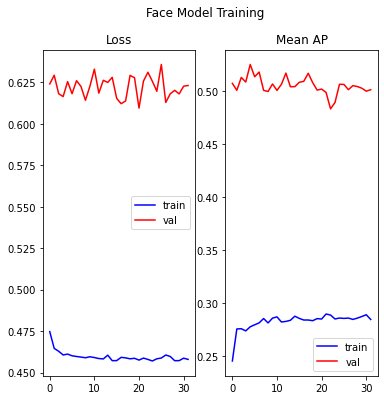

In [ ]:
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (6, 6))
f.suptitle('Face Model Training')
ax1.plot(range(0,len(train_loss)), train_loss, color='Blue')
ax1.plot(range(0,len(val_loss)), val_loss, color='Red')
ax2.plot(range(0,len(train_map)), train_map, color='Blue')
ax2.plot(range(0,len(val_map)), val_map, color='Red')
ax1.legend(['train','val'])
ax2.legend(['train','val'])
ax1.title.set_text('Loss')
ax2.title.set_text('Mean AP')

Test with models of epoch 32

In [ ]:
allMAP = eval(MergerModel, ALL_testDB, 32, testSampler, collate=collate, modal='all',
               device=device, debug_mode=True, tqdm=tqdm)

allMAP = eval(MergerModel, ALL_testDB, 32, None, collate=collate, modal='all',
               device=device, debug_mode=True, tqdm=tqdm)


AveragePrecision: [0.20749219 0.40283018 0.17832494 0.23759925 0.2928866  0.4197253
 0.56945276 0.8959506 ] |8| mAP: 0.40053272247314453



AveragePrecision: [0.82246375 0.7318515  0.1741581  0.22325955 0.16462559 0.31523547
 0.16539083 0.89364374] |8| mAP: 0.43632858991622925


In [ ]:
del MergerModel

### EmbraceNet (final outputs)

In [ ]:
Merge_13_configures ={
	'type':	1,
	'parameters': {
		'num_classes': 8,
		'input_sizes': [8, 8, 8, 8, ],
		'embrace_size': 16,
		'docker_architecture': [[16], [16], [16], [16],],
		'finalouts': True,
		'device': torch.device('cuda'),
    'use_ll': True,
		'll_config': [32,'D','R', 8],
		'trainable_probs': False
		}
}

In [ ]:
MergerModel = MergeClass(uni_models, Merge_13_configures, device)

In [ ]:
all_loss = nn.BCEWithLogitsLoss()
all_opt = Adam(MergerModel.parameters(), lr=0.001, weight_decay=5e-4)

In [ ]:
epoch_start = 0
last_epoch = 16
train_loss = [0] * (last_epoch-epoch_start)
val_loss = [0] * (last_epoch-epoch_start)
train_map = [0] * (last_epoch-epoch_start)
val_map = [0] * (last_epoch-epoch_start)
maxacc = -1
step_val = None
step_save = 4
batch_sz = 32

In [ ]:
# the model is saved as "all_merge13"
for ep in range(epoch_start, last_epoch):
  maxacc = train_step(Model=MergerModel, dataset_t=ALL_trainDB,
                      dataset_v=ALL_valDB, bsz=batch_sz,
                      Loss=all_loss, optimizer=all_opt,
                      collate=collate, epoch=ep,
                      tsampler=trainSampler, vsampler=valSampler,
                      last_epoch=last_epoch, modal='all',
                      device=device, debug_mode=True,
                      tqdm=tqdm, train_loss=train_loss,
                      train_map=train_map, val_loss=val_loss,
                      val_map=val_map, maxacc=maxacc,
                      step2val=step_val, step2save=step_save,
                      checkpointdir='Checkpoints', model_name='all_merge13')
  print('/////////////////////////////////////////////////////////////////')


AveragePrecision: [0.1282597  0.16104685 0.13025506 0.16090323 0.18127802 0.22340508
 0.20537286 0.4431836 ] |8| mAP: 0.20421305298805237



AveragePrecision: [0.12296995 0.23138393 0.25510806 0.30957532 0.5201724  0.6418079
 0.51162446 0.9444309 ] |8| mAP: 0.44213414192199707
- Mean training loss: 0.5028 ; epoch 1
- Mean validation loss: 0.6281 ; epoch 1
- Mean training mAP: 0.2042 ; epoch 1
- Mean validation mAP: 0.4421 ; epoch 1
Model Checkpoints/all_merge13_best.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.12096093 0.17985144 0.14588515 0.16593447 0.21937889 0.22028053
 0.30382854 0.50614077] |8| mAP: 0.23278260231018066



AveragePrecision: [0.1695801  0.30369198 0.28448465 0.36833432 0.5345978  0.6997649
 0.5708274  0.9747784 ] |8| mAP: 0.4882574677467346
- Mean training loss: 0.4757 ; epoch 2
- Mean validation loss: 0.6256 ; epoch 2
- Mean training mAP: 0.2328 ; epoch 2
- Mean validation mAP: 0.4883 ; epoch 2
Model Checkpoints/all_merge13_best.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.1414838  0.21089676 0.1507253  0.17094326 0.23822142 0.23186745
 0.35555258 0.5333323 ] |8| mAP: 0.2541278600692749



AveragePrecision: [0.20986666 0.35038185 0.30137765 0.37568945 0.57873243 0.67269665
 0.54408294 0.9741467 ] |8| mAP: 0.5008717775344849
- Mean training loss: 0.4703 ; epoch 3
- Mean validation loss: 0.6336 ; epoch 3
- Mean training mAP: 0.2541 ; epoch 3
- Mean validation mAP: 0.5009 ; epoch 3
Model Checkpoints/all_merge13_best.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.13641126 0.22847134 0.14689441 0.18083984 0.23770307 0.23170938
 0.3749087  0.5335438 ] |8| mAP: 0.25881022214889526



AveragePrecision: [0.22075272 0.36349005 0.27088115 0.33427897 0.5804253  0.6704903
 0.5455814  0.9764329 ] |8| mAP: 0.4952916204929352
- Mean training loss: 0.4685 ; epoch 4
- Mean validation loss: 0.6216 ; epoch 4
- Mean training mAP: 0.2588 ; epoch 4
- Mean validation mAP: 0.4953 ; epoch 4
Model Checkpoints/all_merge13_best.pth saved
Model Checkpoints/all_merge13_last.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.14580782 0.23007365 0.15224686 0.1758193  0.24272892 0.23423588
 0.36954185 0.53734314] |8| mAP: 0.2609747052192688



AveragePrecision: [0.19112101 0.34928066 0.28831795 0.36806545 0.57143164 0.6712676
 0.5724517  0.9841436 ] |8| mAP: 0.49950993061065674
- Mean training loss: 0.4667 ; epoch 5
- Mean validation loss: 0.6262 ; epoch 5
- Mean training mAP: 0.2610 ; epoch 5
- Mean validation mAP: 0.4995 ; epoch 5
Model Checkpoints/all_merge13_best.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.14792652 0.24490254 0.15016808 0.18331772 0.2508838  0.23770463
 0.3556613  0.5413893 ] |8| mAP: 0.2639942467212677



AveragePrecision: [0.24961099 0.37499905 0.28679585 0.37024584 0.59316915 0.6591735
 0.5801179  0.9798451 ] |8| mAP: 0.5117446780204773
- Mean training loss: 0.4659 ; epoch 6
- Mean validation loss: 0.6163 ; epoch 6
- Mean training mAP: 0.2640 ; epoch 6
- Mean validation mAP: 0.5117 ; epoch 6
Model Checkpoints/all_merge13_best.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.15329038 0.2521474  0.14711691 0.17936854 0.24407782 0.22932671
 0.3791584  0.54368204] |8| mAP: 0.2660210132598877



AveragePrecision: [0.24529715 0.35249206 0.29224834 0.36945596 0.57525265 0.6768317
 0.58026445 0.97537625] |8| mAP: 0.5084023475646973
- Mean training loss: 0.4635 ; epoch 7
- Mean validation loss: 0.6264 ; epoch 7
- Mean training mAP: 0.2660 ; epoch 7
- Mean validation mAP: 0.5084 ; epoch 7
Model Checkpoints/all_merge13_best.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.15049697 0.258109   0.15350325 0.1803882  0.2537859  0.23996346
 0.37572092 0.54276305] |8| mAP: 0.2693413496017456



AveragePrecision: [0.2261012  0.34955835 0.25401944 0.35204414 0.5654613  0.6712775
 0.5700448  0.9770474 ] |8| mAP: 0.49569427967071533
- Mean training loss: 0.4654 ; epoch 8
- Mean validation loss: 0.6087 ; epoch 8
- Mean training mAP: 0.2693 ; epoch 8
- Mean validation mAP: 0.4957 ; epoch 8
Model Checkpoints/all_merge13_best.pth saved
Model Checkpoints/all_merge13_last.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.15160185 0.2745506  0.15061757 0.17614907 0.24836983 0.23497567
 0.38107195 0.5468943 ] |8| mAP: 0.2705288529396057



AveragePrecision: [0.20810287 0.33544242 0.26744837 0.35709634 0.5473268  0.6548999
 0.53931093 0.9826511 ] |8| mAP: 0.48653486371040344
- Mean training loss: 0.4634 ; epoch 9
- Mean validation loss: 0.6205 ; epoch 9
- Mean training mAP: 0.2705 ; epoch 9
- Mean validation mAP: 0.4865 ; epoch 9
Model Checkpoints/all_merge13_best.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.15147732 0.2566624  0.14945164 0.17844547 0.24746674 0.23485912
 0.3795053  0.5413972 ] |8| mAP: 0.2674081325531006



AveragePrecision: [0.27157888 0.3849492  0.28684607 0.3647937  0.52990234 0.6807261
 0.5472735  0.9844883 ] |8| mAP: 0.5063197612762451
- Mean training loss: 0.4635 ; epoch 10
- Mean validation loss: 0.6229 ; epoch 10
- Mean training mAP: 0.2674 ; epoch 10
- Mean validation mAP: 0.5063 ; epoch 10
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.15487401 0.28012213 0.16109806 0.18646654 0.25257728 0.23925522
 0.37721708 0.5389232 ] |8| mAP: 0.27381670475006104



AveragePrecision: [0.2583825  0.38695624 0.26607463 0.38768893 0.5531957  0.69176143
 0.579612   0.98142684] |8| mAP: 0.5131372809410095
- Mean training loss: 0.4656 ; epoch 11
- Mean validation loss: 0.6191 ; epoch 11
- Mean training mAP: 0.2738 ; epoch 11
- Mean validation mAP: 0.5131 ; epoch 11
Model Checkpoints/all_merge13_best.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.15149038 0.26285294 0.16078492 0.1821556  0.2505048  0.23929508
 0.38840762 0.5408707 ] |8| mAP: 0.2720452547073364



AveragePrecision: [0.27965266 0.3456267  0.27739134 0.3754915  0.55161333 0.6635905
 0.5594025  0.9863055 ] |8| mAP: 0.5048842430114746
- Mean training loss: 0.4651 ; epoch 12
- Mean validation loss: 0.6170 ; epoch 12
- Mean training mAP: 0.2720 ; epoch 12
- Mean validation mAP: 0.5049 ; epoch 12
Model Checkpoints/all_merge13_last.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.15062718 0.26927045 0.14916486 0.19583422 0.23501897 0.24009567
 0.37190786 0.544985  ] |8| mAP: 0.26961302757263184



AveragePrecision: [0.2778261  0.39920384 0.28103155 0.37603047 0.557324   0.7034733
 0.58362484 0.9821606 ] |8| mAP: 0.5200843214988708
- Mean training loss: 0.4629 ; epoch 13
- Mean validation loss: 0.6334 ; epoch 13
- Mean training mAP: 0.2696 ; epoch 13
- Mean validation mAP: 0.5201 ; epoch 13
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.15585932 0.27420354 0.14322522 0.18126898 0.25056776 0.23633192
 0.37722394 0.5444793 ] |8| mAP: 0.2703949809074402



AveragePrecision: [0.24519657 0.37569168 0.31035787 0.4081954  0.55418724 0.6552326
 0.5662238  0.98638886] |8| mAP: 0.5126842260360718
- Mean training loss: 0.4633 ; epoch 14
- Mean validation loss: 0.6313 ; epoch 14
- Mean training mAP: 0.2704 ; epoch 14
- Mean validation mAP: 0.5127 ; epoch 14
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.15439564 0.27652317 0.15409191 0.1915539  0.2546979  0.24499977
 0.39203572 0.5445396 ] |8| mAP: 0.27660471200942993



AveragePrecision: [0.23796716 0.34036964 0.2906902  0.38760555 0.594699   0.6501253
 0.56810635 0.9790031 ] |8| mAP: 0.5060707926750183
- Mean training loss: 0.4620 ; epoch 15
- Mean validation loss: 0.6155 ; epoch 15
- Mean training mAP: 0.2766 ; epoch 15
- Mean validation mAP: 0.5061 ; epoch 15
Model Checkpoints/all_merge13_best.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.1548132  0.27533454 0.15181583 0.18188468 0.25649408 0.2442517
 0.3800966  0.5452213 ] |8| mAP: 0.2737390100955963



AveragePrecision: [0.2538921  0.38029268 0.2651898  0.35905358 0.54374146 0.65538275
 0.5304473  0.97974   ] |8| mAP: 0.49596744775772095
- Mean training loss: 0.4622 ; epoch 16
- Mean validation loss: 0.6266 ; epoch 16
- Mean training mAP: 0.2737 ; epoch 16
- Mean validation mAP: 0.4960 ; epoch 16
Model Checkpoints/all_merge13_last.pth saved
/////////////////////////////////////////////////////////////////


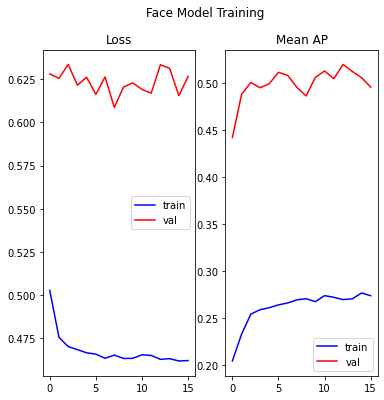

In [ ]:
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (6, 6))
f.suptitle('Face Model Training')
ax1.plot(range(0,len(train_loss)), train_loss, color='Blue')
ax1.plot(range(0,len(val_loss)), val_loss, color='Red')
ax2.plot(range(0,len(train_map)), train_map, color='Blue')
ax2.plot(range(0,len(val_map)), val_map, color='Red')
ax1.legend(['train','val'])
ax2.legend(['train','val'])
ax1.title.set_text('Loss')
ax2.title.set_text('Mean AP')

Test with model of epoch 16

In [ ]:
allMAP = eval(MergerModel, ALL_testDB, 32, testSampler, collate=collate, modal='all',
               device=device, debug_mode=True, tqdm=tqdm)

allMAP = eval(MergerModel, ALL_testDB, 32, None, collate=collate, modal='all',
               device=device, debug_mode=True, tqdm=tqdm)


AveragePrecision: [0.20576033 0.3947972  0.17282352 0.23543918 0.2973399  0.42402366
 0.5541769  0.8859994 ] |8| mAP: 0.3962950110435486



AveragePrecision: [0.81559134 0.7330155  0.18228856 0.22475922 0.15781854 0.30196607
 0.16520067 0.8862543 ] |8| mAP: 0.4333617687225342


In [ ]:
del MergerModel

### EmbraceNet+

In [ ]:
Merge_5_configures = {
	'type':	5,
	'parameters': {
		'num_classes': 8,
		'input_sizes': 4,
		'final_input_sizes': 4,
		'embrace1_param': {
			'input_size_list': [512, 512, 512, 512, ],
			'embracement_size': 512,
			'docker_arch': [[1024, 'D', 512], [1024, 'D', 512], [1024, 'D', 512], [1024, 'D', 512],],
			'device': torch.device('cuda'),
		},
		'embrace2_param': {
			'input_size_list': [8, 8, 8, 8, ],
			'embracement_size': 32,
			'docker_arch': [[64, 'D', 32], [64, 'D', 32], [64, 'D', 32], [64, 'D', 32],],
			'device': torch.device('cuda'),
		},
		'embrace3_param': {
			'input_size_list': [128, 32, 8, 32,],
			'embracement_size': 64,
			'docker_arch': [[64], [64], [64], [64],],
			'device': torch.device('cuda'),
		},
		'wsum_confg': {
      'number_modals': 4,
			'outchannels': 1,
			'probabilities': None,
			'trainable': False,
			'mode': 'tensor', # 'convs', #
			'device': torch.device('cuda'),
    },
		'device': torch.device('cuda'),
		'trainable_probs': False,
		'useffinal': True,
		'use_ws': True,
		'use_ll': [True, False, True],
		'll_configs': [
			{'config': [128] ,
			'embrace_size': 512,},
			{},
			{'config': [8] ,
			'embrace_size': 64,}
		]}
}

In [ ]:
MergerModel = MergeClass(uni_models, Merge_5_configures, device)

In [ ]:
all_loss = nn.BCEWithLogitsLoss()
all_opt = Adam(MergerModel.parameters(), lr=0.001, weight_decay=5e-4)

In [ ]:
epoch_start = 0
last_epoch = 24
train_loss = [0] * (last_epoch-epoch_start)
val_loss = [0] * (last_epoch-epoch_start)
train_map = [0] * (last_epoch-epoch_start)
val_map = [0] * (last_epoch-epoch_start)
maxacc = -1
step_val = None
step_save = 1
batch_sz = 32

In [ ]:
# the model is saved as "all_mergenew"
for ep in range(epoch_start, last_epoch):
  maxacc = train_step(Model=MergerModel, dataset_t=ALL_trainDB,
                      dataset_v=ALL_valDB, bsz=batch_sz,
                      Loss=all_loss, optimizer=all_opt,
                      collate=collate, epoch=ep,
                      tsampler=trainSampler, vsampler=valSampler,
                      last_epoch=last_epoch, modal='all',
                      device=device, debug_mode=True,
                      tqdm=tqdm, train_loss=train_loss,
                      train_map=train_map, val_loss=val_loss,
                      val_map=val_map, maxacc=maxacc,
                      step2val=step_val, step2save=step_save,
                      checkpointdir='Checkpoints', model_name='all_mergenew')
  print('/////////////////////////////////////////////////////////////////')


AveragePrecision: [0.12540692 0.18633199 0.14568256 0.16774788 0.21290231 0.23954019
 0.30459005 0.4924013 ] |8| mAP: 0.23432540893554688



AveragePrecision: [0.17570391 0.30828983 0.25690746 0.33518478 0.50933135 0.6175037
 0.54340255 0.9801803 ] |8| mAP: 0.465813010931015
- Mean training loss: 0.4741 ; epoch 1
- Mean validation loss: 0.6213 ; epoch 1
- Mean training mAP: 0.2343 ; epoch 1
- Mean validation mAP: 0.4658 ; epoch 1
Model Checkpoints/all_mergenew_best.pth saved
Model Checkpoints/all_mergenew_last.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.14639904 0.26669082 0.16263609 0.19475293 0.24466507 0.25195646
 0.3986479  0.5502467 ] |8| mAP: 0.2769993841648102



AveragePrecision: [0.2819802  0.3456343  0.25822487 0.35312727 0.5638456  0.6368868
 0.5516783  0.97584116] |8| mAP: 0.49590232968330383
- Mean training loss: 0.4607 ; epoch 2
- Mean validation loss: 0.6193 ; epoch 2
- Mean training mAP: 0.2770 ; epoch 2
- Mean validation mAP: 0.4959 ; epoch 2
Model Checkpoints/all_mergenew_best.pth saved
Model Checkpoints/all_mergenew_last.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.15854017 0.283894   0.16057876 0.18007195 0.2518157  0.25747356
 0.40667692 0.55684036] |8| mAP: 0.28198641538619995



AveragePrecision: [0.25976628 0.36248362 0.2912586  0.36569163 0.5478735  0.6546258
 0.54658276 0.9814678 ] |8| mAP: 0.5012187361717224
- Mean training loss: 0.4569 ; epoch 3
- Mean validation loss: 0.6242 ; epoch 3
- Mean training mAP: 0.2820 ; epoch 3
- Mean validation mAP: 0.5012 ; epoch 3
Model Checkpoints/all_mergenew_best.pth saved
Model Checkpoints/all_mergenew_last.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.17326544 0.2824405  0.16852407 0.18617985 0.26349694 0.26268053
 0.4000048  0.5638249 ] |8| mAP: 0.2875521183013916



AveragePrecision: [0.2413563  0.3781061  0.28443536 0.3272575  0.5763854  0.64834875
 0.5616329  0.98307365] |8| mAP: 0.5000745058059692
- Mean training loss: 0.4589 ; epoch 4
- Mean validation loss: 0.6253 ; epoch 4
- Mean training mAP: 0.2876 ; epoch 4
- Mean validation mAP: 0.5001 ; epoch 4
Model Checkpoints/all_mergenew_best.pth saved
Model Checkpoints/all_mergenew_last.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.16169156 0.29144877 0.15906264 0.19151068 0.25427303 0.26117516
 0.40877473 0.56516963] |8| mAP: 0.2866382598876953



AveragePrecision: [0.28570482 0.41344342 0.26571602 0.35108975 0.55045456 0.61779016
 0.5794276  0.9817943 ] |8| mAP: 0.5056775808334351
- Mean training loss: 0.4579 ; epoch 5
- Mean validation loss: 0.6252 ; epoch 5
- Mean training mAP: 0.2866 ; epoch 5
- Mean validation mAP: 0.5057 ; epoch 5
Model Checkpoints/all_mergenew_last.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.16859989 0.29166064 0.15958782 0.19830896 0.25648513 0.26646814
 0.40837714 0.562424  ] |8| mAP: 0.28898894786834717



AveragePrecision: [0.22945663 0.37245125 0.2606075  0.36337334 0.54442894 0.6085817
 0.5693943  0.9781426 ] |8| mAP: 0.490804523229599
- Mean training loss: 0.4589 ; epoch 6
- Mean validation loss: 0.6168 ; epoch 6
- Mean training mAP: 0.2890 ; epoch 6
- Mean validation mAP: 0.4908 ; epoch 6
Model Checkpoints/all_mergenew_best.pth saved
Model Checkpoints/all_mergenew_last.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.17099318 0.28999722 0.16518138 0.19285282 0.25381365 0.26778084
 0.40464097 0.56086665] |8| mAP: 0.28826582431793213



AveragePrecision: [0.28258643 0.4082695  0.25362268 0.31954545 0.5535703  0.63195497
 0.55534464 0.9805025 ] |8| mAP: 0.4981745481491089
- Mean training loss: 0.4582 ; epoch 7
- Mean validation loss: 0.6213 ; epoch 7
- Mean training mAP: 0.2883 ; epoch 7
- Mean validation mAP: 0.4982 ; epoch 7
Model Checkpoints/all_mergenew_last.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.16266906 0.2824018  0.16441855 0.19533832 0.25608996 0.274876
 0.39914894 0.5618363 ] |8| mAP: 0.28709736466407776



AveragePrecision: [0.24469768 0.38467148 0.27792782 0.3549402  0.6156588  0.6004124
 0.61248684 0.9819266 ] |8| mAP: 0.50909024477005
- Mean training loss: 0.4584 ; epoch 8
- Mean validation loss: 0.6315 ; epoch 8
- Mean training mAP: 0.2871 ; epoch 8
- Mean validation mAP: 0.5091 ; epoch 8
Model Checkpoints/all_mergenew_last.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.16843347 0.30222103 0.1656441  0.18805411 0.24898003 0.26948807
 0.40756217 0.55998284] |8| mAP: 0.28879573941230774



AveragePrecision: [0.2678429  0.38584256 0.27705088 0.35048163 0.5413634  0.6047353
 0.58181983 0.9788595 ] |8| mAP: 0.4984995126724243
- Mean training loss: 0.4567 ; epoch 9
- Mean validation loss: 0.6175 ; epoch 9
- Mean training mAP: 0.2888 ; epoch 9
- Mean validation mAP: 0.4985 ; epoch 9
Model Checkpoints/all_mergenew_last.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.17359349 0.2969397  0.17530406 0.17628223 0.26550707 0.273849
 0.4131707  0.5552892 ] |8| mAP: 0.29124194383621216



AveragePrecision: [0.28873846 0.40991002 0.30899027 0.3333865  0.6056447  0.6071846
 0.60055715 0.9811631 ] |8| mAP: 0.5169468522071838
- Mean training loss: 0.4579 ; epoch 10
- Mean validation loss: 0.6277 ; epoch 10
- Mean training mAP: 0.2912 ; epoch 10
- Mean validation mAP: 0.5169 ; epoch 10
Model Checkpoints/all_mergenew_best.pth saved
Model Checkpoints/all_mergenew_last.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.17210679 0.29576874 0.1677129  0.18749677 0.25972867 0.2744511
 0.41800433 0.5664629 ] |8| mAP: 0.29271650314331055



AveragePrecision: [0.25721487 0.3837434  0.26674205 0.34313715 0.53939956 0.60173136
 0.59534913 0.9816831 ] |8| mAP: 0.49612507224082947
- Mean training loss: 0.4567 ; epoch 11
- Mean validation loss: 0.6256 ; epoch 11
- Mean training mAP: 0.2927 ; epoch 11
- Mean validation mAP: 0.4961 ; epoch 11
Model Checkpoints/all_mergenew_best.pth saved
Model Checkpoints/all_mergenew_last.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.16594312 0.29842862 0.16274288 0.18668242 0.25566864 0.2810445
 0.41362244 0.5610184 ] |8| mAP: 0.2906438708305359



AveragePrecision: [0.28010735 0.39357182 0.2599919  0.35911852 0.5911901  0.60295284
 0.5909454  0.98227006] |8| mAP: 0.5075185298919678
- Mean training loss: 0.4557 ; epoch 12
- Mean validation loss: 0.6252 ; epoch 12
- Mean training mAP: 0.2906 ; epoch 12
- Mean validation mAP: 0.5075 ; epoch 12
Model Checkpoints/all_mergenew_last.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.16667823 0.27946138 0.16182272 0.19522274 0.25508553 0.27148038
 0.41690654 0.5674309 ] |8| mAP: 0.2892610430717468



AveragePrecision: [0.2907206  0.41419515 0.27021974 0.3912343  0.57703906 0.6049823
 0.58128315 0.9847666 ] |8| mAP: 0.5143051147460938
- Mean training loss: 0.4573 ; epoch 13
- Mean validation loss: 0.6270 ; epoch 13
- Mean training mAP: 0.2893 ; epoch 13
- Mean validation mAP: 0.5143 ; epoch 13
Model Checkpoints/all_mergenew_last.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.16729946 0.29643205 0.15589806 0.18672577 0.2680165  0.2867395
 0.42133737 0.5684485 ] |8| mAP: 0.29386216402053833



AveragePrecision: [0.28274795 0.36580417 0.2697808  0.3617074  0.57220703 0.58756846
 0.6088804  0.9814524 ] |8| mAP: 0.5037685632705688
- Mean training loss: 0.4551 ; epoch 14
- Mean validation loss: 0.6183 ; epoch 14
- Mean training mAP: 0.2939 ; epoch 14
- Mean validation mAP: 0.5038 ; epoch 14
Model Checkpoints/all_mergenew_best.pth saved
Model Checkpoints/all_mergenew_last.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.17630172 0.27673453 0.16596329 0.18825115 0.25544232 0.27787378
 0.41360417 0.5591458 ] |8| mAP: 0.28916460275650024



AveragePrecision: [0.31345135 0.38610283 0.26527512 0.36488965 0.57349586 0.5658296
 0.5689106  0.9849386 ] |8| mAP: 0.5028616786003113
- Mean training loss: 0.4565 ; epoch 15
- Mean validation loss: 0.6248 ; epoch 15
- Mean training mAP: 0.2892 ; epoch 15
- Mean validation mAP: 0.5029 ; epoch 15
Model Checkpoints/all_mergenew_last.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.17356686 0.30068615 0.16679989 0.1922189  0.26593074 0.27825853
 0.40186444 0.5629119 ] |8| mAP: 0.29277968406677246



AveragePrecision: [0.32369468 0.41608816 0.27969292 0.3846393  0.5694282  0.60137796
 0.5527916  0.9846894 ] |8| mAP: 0.5140502452850342
- Mean training loss: 0.4574 ; epoch 16
- Mean validation loss: 0.6290 ; epoch 16
- Mean training mAP: 0.2928 ; epoch 16
- Mean validation mAP: 0.5141 ; epoch 16
Model Checkpoints/all_mergenew_last.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.17442502 0.28543872 0.16253962 0.19361763 0.25653017 0.2786892
 0.41164795 0.5605256 ] |8| mAP: 0.29042673110961914



AveragePrecision: [0.29594037 0.4099535  0.29205656 0.36055213 0.56391627 0.5568703
 0.5892937  0.9832423 ] |8| mAP: 0.5064781904220581
- Mean training loss: 0.4554 ; epoch 17
- Mean validation loss: 0.6191 ; epoch 17
- Mean training mAP: 0.2904 ; epoch 17
- Mean validation mAP: 0.5065 ; epoch 17
Model Checkpoints/all_mergenew_last.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.16957086 0.29909796 0.1652577  0.18517767 0.25547037 0.27570444
 0.42149338 0.5644025 ] |8| mAP: 0.29202187061309814



AveragePrecision: [0.2936927  0.3846672  0.28389582 0.39250323 0.5825567  0.58691716
 0.58751535 0.98076385] |8| mAP: 0.5115640163421631
- Mean training loss: 0.4560 ; epoch 18
- Mean validation loss: 0.6251 ; epoch 18
- Mean training mAP: 0.2920 ; epoch 18
- Mean validation mAP: 0.5116 ; epoch 18
Model Checkpoints/all_mergenew_last.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.16238312 0.2885116  0.16859537 0.19459504 0.26561463 0.27406237
 0.4102477  0.5629061 ] |8| mAP: 0.290864497423172



AveragePrecision: [0.29102603 0.3969139  0.306611   0.37462863 0.5789245  0.5802954
 0.60522676 0.9832673 ] |8| mAP: 0.5146117210388184
- Mean training loss: 0.4567 ; epoch 19
- Mean validation loss: 0.6245 ; epoch 19
- Mean training mAP: 0.2909 ; epoch 19
- Mean validation mAP: 0.5146 ; epoch 19
Model Checkpoints/all_mergenew_last.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.1849614  0.30803394 0.16414231 0.18894035 0.26855424 0.2893326
 0.40794393 0.57046956] |8| mAP: 0.297797292470932



AveragePrecision: [0.2937436  0.41948822 0.26539564 0.33326015 0.5684973  0.5870518
 0.5968563  0.9857294 ] |8| mAP: 0.5062528252601624
- Mean training loss: 0.4577 ; epoch 20
- Mean validation loss: 0.6272 ; epoch 20
- Mean training mAP: 0.2978 ; epoch 20
- Mean validation mAP: 0.5063 ; epoch 20
Model Checkpoints/all_mergenew_best.pth saved
Model Checkpoints/all_mergenew_last.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.16572094 0.28874025 0.15994374 0.18576534 0.2559359  0.28342485
 0.44003382 0.5613404 ] |8| mAP: 0.29261314868927



AveragePrecision: [0.27307433 0.403373   0.28401688 0.3561288  0.5933137  0.58722323
 0.589652   0.9791321 ] |8| mAP: 0.5082392692565918
- Mean training loss: 0.4555 ; epoch 21
- Mean validation loss: 0.6220 ; epoch 21
- Mean training mAP: 0.2926 ; epoch 21
- Mean validation mAP: 0.5082 ; epoch 21
Model Checkpoints/all_mergenew_last.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.17692773 0.3126979  0.17119217 0.19793911 0.26175255 0.28319326
 0.41871542 0.56203467] |8| mAP: 0.29805660247802734



AveragePrecision: [0.2516208  0.3730218  0.27570835 0.36342236 0.5891106  0.60182846
 0.5915356  0.98475313] |8| mAP: 0.5038751363754272
- Mean training loss: 0.4562 ; epoch 22
- Mean validation loss: 0.6185 ; epoch 22
- Mean training mAP: 0.2981 ; epoch 22
- Mean validation mAP: 0.5039 ; epoch 22
Model Checkpoints/all_mergenew_best.pth saved
Model Checkpoints/all_mergenew_last.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.17372575 0.29339957 0.16776454 0.19154602 0.25699988 0.28127718
 0.42346618 0.5716044 ] |8| mAP: 0.2949729561805725



AveragePrecision: [0.23341905 0.3557749  0.26988643 0.36175    0.5493934  0.5900808
 0.5898933  0.9812374 ] |8| mAP: 0.4914294183254242
- Mean training loss: 0.4547 ; epoch 23
- Mean validation loss: 0.6252 ; epoch 23
- Mean training mAP: 0.2950 ; epoch 23
- Mean validation mAP: 0.4914 ; epoch 23
Model Checkpoints/all_mergenew_last.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.17391604 0.29500043 0.1563366  0.19951057 0.263426   0.2718459
 0.40945512 0.5675709 ] |8| mAP: 0.2921326756477356



AveragePrecision: [0.2506472  0.36256313 0.26861963 0.36598516 0.55331165 0.5775434
 0.59261256 0.9827505 ] |8| mAP: 0.4942541718482971
- Mean training loss: 0.4565 ; epoch 24
- Mean validation loss: 0.6179 ; epoch 24
- Mean training mAP: 0.2921 ; epoch 24
- Mean validation mAP: 0.4943 ; epoch 24
Model Checkpoints/all_mergenew_last.pth saved
/////////////////////////////////////////////////////////////////


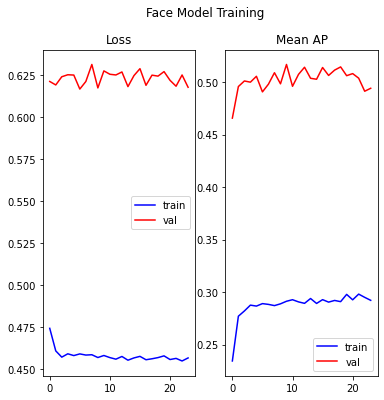

In [ ]:
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (6, 6))
f.suptitle('Face Model Training')
ax1.plot(range(0,len(train_loss)), train_loss, color='Blue')
ax1.plot(range(0,len(val_loss)), val_loss, color='Red')
ax2.plot(range(0,len(train_map)), train_map, color='Blue')
ax2.plot(range(0,len(val_map)), val_map, color='Red')
ax1.legend(['train','val'])
ax2.legend(['train','val'])
ax1.title.set_text('Loss')
ax2.title.set_text('Mean AP')

In [ ]:
epoch_start = 24
last_epoch = 32
train_loss = [0] * (last_epoch)
val_loss = [0] * (last_epoch)
train_map = [0] * (last_epoch)
val_map = [0] * (last_epoch)
# maxacc = -1
step_val = None
step_save = 1
batch_sz = 32

In [ ]:
for ep in range(epoch_start, last_epoch):
  maxacc = train_step(Model=MergerModel, dataset_t=ALL_trainDB,
                      dataset_v=ALL_valDB, bsz=batch_sz,
                      Loss=all_loss, optimizer=all_opt,
                      collate=collate, epoch=ep,
                      tsampler=trainSampler, vsampler=valSampler,
                      last_epoch=last_epoch, modal='all',
                      device=device, debug_mode=True,
                      tqdm=tqdm, train_loss=train_loss,
                      train_map=train_map, val_loss=val_loss,
                      val_map=val_map, maxacc=maxacc,
                      step2val=step_val, step2save=step_save,
                      checkpointdir='Checkpoints', model_name='all_mergenew')
  print('/////////////////////////////////////////////////////////////////')


AveragePrecision: [0.16928351 0.29458427 0.16375309 0.19919963 0.26346633 0.27537364
 0.41225165 0.56750923] |8| mAP: 0.29317766427993774



AveragePrecision: [0.22121336 0.31876755 0.27871585 0.3616932  0.5681801  0.60239077
 0.5856535  0.9787005 ] |8| mAP: 0.4894143342971802
- Mean training loss: 0.4556 ; epoch 25
- Mean validation loss: 0.6218 ; epoch 25
- Mean training mAP: 0.2932 ; epoch 25
- Mean validation mAP: 0.4894 ; epoch 25
Model Checkpoints/all_mergenew_best.pth saved
Model Checkpoints/all_mergenew_last.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.17798421 0.30281666 0.16506833 0.19912626 0.25872555 0.2826063
 0.41800886 0.56222135] |8| mAP: 0.2958196997642517



AveragePrecision: [0.2707608  0.36418402 0.26644644 0.34476924 0.5518253  0.6126773
 0.5880986  0.9820285 ] |8| mAP: 0.4975987672805786
- Mean training loss: 0.4588 ; epoch 26
- Mean validation loss: 0.6204 ; epoch 26
- Mean training mAP: 0.2958 ; epoch 26
- Mean validation mAP: 0.4976 ; epoch 26
Model Checkpoints/all_mergenew_best.pth saved
Model Checkpoints/all_mergenew_last.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.17030153 0.28767544 0.16992852 0.19392028 0.26469824 0.2858308
 0.40824053 0.5620797 ] |8| mAP: 0.2928343713283539



AveragePrecision: [0.28976446 0.40532166 0.28857493 0.3381773  0.5874184  0.5801777
 0.5878404  0.97758955] |8| mAP: 0.5068580508232117
- Mean training loss: 0.4569 ; epoch 27
- Mean validation loss: 0.6245 ; epoch 27
- Mean training mAP: 0.2928 ; epoch 27
- Mean validation mAP: 0.5069 ; epoch 27
Model Checkpoints/all_mergenew_last.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.17227201 0.29433104 0.16859576 0.19947012 0.2643346  0.28201404
 0.4113389  0.56386364] |8| mAP: 0.29452750086784363



AveragePrecision: [0.29699567 0.40300164 0.2593547  0.32122034 0.5602442  0.5749989
 0.5872345  0.9860105 ] |8| mAP: 0.4986325800418854
- Mean training loss: 0.4551 ; epoch 28
- Mean validation loss: 0.6186 ; epoch 28
- Mean training mAP: 0.2945 ; epoch 28
- Mean validation mAP: 0.4986 ; epoch 28
Model Checkpoints/all_mergenew_last.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.16406451 0.2930214  0.16762166 0.19807038 0.26549646 0.2819249
 0.40524423 0.5593825 ] |8| mAP: 0.29185324907302856



AveragePrecision: [0.27623293 0.4111228  0.27163842 0.35112274 0.57910055 0.57450956
 0.5824186  0.98395103] |8| mAP: 0.5037620663642883
- Mean training loss: 0.4582 ; epoch 29
- Mean validation loss: 0.6207 ; epoch 29
- Mean training mAP: 0.2919 ; epoch 29
- Mean validation mAP: 0.5038 ; epoch 29
Model Checkpoints/all_mergenew_last.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.17596386 0.2912797  0.15958044 0.19911669 0.26705515 0.27607268
 0.40794605 0.56504834] |8| mAP: 0.29275786876678467



AveragePrecision: [0.23024222 0.36405912 0.28154257 0.33582687 0.58471316 0.581722
 0.57052714 0.9800863 ] |8| mAP: 0.49108994007110596
- Mean training loss: 0.4571 ; epoch 30
- Mean validation loss: 0.6205 ; epoch 30
- Mean training mAP: 0.2928 ; epoch 30
- Mean validation mAP: 0.4911 ; epoch 30
Model Checkpoints/all_mergenew_last.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.16819425 0.29423866 0.17094074 0.18530604 0.2725252  0.26741073
 0.4234423  0.5615958 ] |8| mAP: 0.29295670986175537



AveragePrecision: [0.2838595  0.4086712  0.27205324 0.34552404 0.57605076 0.57482743
 0.5754491  0.98498863] |8| mAP: 0.5026779770851135
- Mean training loss: 0.4571 ; epoch 31
- Mean validation loss: 0.6326 ; epoch 31
- Mean training mAP: 0.2930 ; epoch 31
- Mean validation mAP: 0.5027 ; epoch 31
Model Checkpoints/all_mergenew_last.pth saved
/////////////////////////////////////////////////////////////////



AveragePrecision: [0.17205246 0.2929783  0.15527377 0.19191769 0.26849633 0.27529132
 0.41871932 0.55515605] |8| mAP: 0.29123565554618835



AveragePrecision: [0.28503203 0.398341   0.28133866 0.36484566 0.60065204 0.5780164
 0.6065458  0.9849865 ] |8| mAP: 0.5124697685241699
- Mean training loss: 0.4542 ; epoch 32
- Mean validation loss: 0.6095 ; epoch 32
- Mean training mAP: 0.2912 ; epoch 32
- Mean validation mAP: 0.5125 ; epoch 32
Model Checkpoints/all_mergenew_last.pth saved
/////////////////////////////////////////////////////////////////


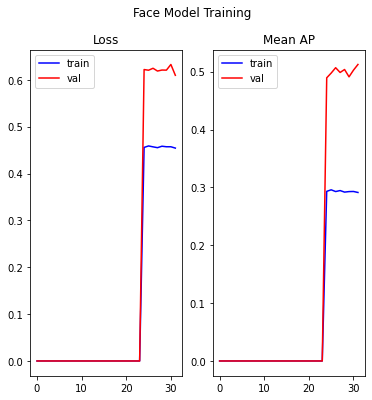

In [ ]:
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (6, 6))
f.suptitle('Face Model Training')
ax1.plot(range(0,len(train_loss)), train_loss, color='Blue')
ax1.plot(range(0,len(val_loss)), val_loss, color='Red')
ax2.plot(range(0,len(train_map)), train_map, color='Blue')
ax2.plot(range(0,len(val_map)), val_map, color='Red')
ax1.legend(['train','val'])
ax2.legend(['train','val'])
ax1.title.set_text('Loss')
ax2.title.set_text('Mean AP')

Test with the model of epoch 32

In [ ]:
# ENTIRE MODEL
allMAP = eval(MergerModel, ALL_testDB, 32, None, collate=collate, modal='all',
               device=device, debug_mode=True, tqdm=tqdm)


AveragePrecision: [0.82513505 0.72446233 0.1815189  0.22447996 0.1811178  0.3194154
 0.17737855 0.8909685 ] |8| mAP: 0.4405595660209656


In [ ]:
# MODEL WITHOUT USE THE EXTRA CONCATENATION
MergerModel.MergeModel.UseFinalsInFinal = False

allMAP = eval(MergerModel, ALL_testDB, 32, None, collate=collate, modal='all',
               device=device, debug_mode=True, tqdm=tqdm)


AveragePrecision: [0.81079066 0.7288113  0.17657547 0.22652546 0.16125049 0.29445174
 0.16261525 0.8897318 ] |8| mAP: 0.43134403228759766


In [ ]:
# MODEL WITHOUT USE THE EXTRA WEIGHTED SUM
MergerModel.MergeModel.UseFinalsInFinal = True
MergerModel.MergeModel.UseWSum = False

allMAP = eval(MergerModel, ALL_testDB, 32, None, collate=collate, modal='all',
               device=device, debug_mode=True, tqdm=tqdm)


AveragePrecision: [0.8200116  0.7188488  0.17372775 0.22396612 0.16620539 0.31322172
 0.16619036 0.88649625] |8| mAP: 0.43358349800109863


In [ ]:
# MODEL WITHOUT USE BOTH EXTRA FUSION METHODS
MergerModel.MergeModel.UseFinalsInFinal = False
MergerModel.MergeModel.UseWSum=False

allMAP = eval(MergerModel, ALL_testDB, 32, None, collate=collate, modal='all',
               device=device, debug_mode=True, tqdm=tqdm)


AveragePrecision: [0.7631757  0.5578809  0.15705545 0.19717184 0.09404789 0.25957066
 0.0943376  0.8413674 ] |8| mAP: 0.3705759346485138


In [ ]:
del MergerModel

### Concant model

In [ ]:
class Concat(nn.Module):
  def __init__(self, n_features, n_classes):
    super(Concat, self).__init__()
    self.fc = nn.Sequential(nn.Linear(n_features,n_classes))
  
  def forward(self, finalouts):
    return self.fc(finalouts)

In [ ]:
class MergeClass():
  def __init__(self, nclasses, nfeatures, models={}, device=torch.device('cpu')):
    self.Modalities = models
    self.Device = device
    self.MergeModel = Concat(nfeatures, nclasses).to(self.Device)

  def parameters(self):
    return self.MergeModel.parameters()
  
  def train(self):
    self.MergeModel.train()
  
  def eval(self):
    self.MergeModel.eval()
  
  def state_dict(self):
    return self.MergeModel.state_dict()
  def load_state_dict(self, dict):
    self.MergeModel.load_state_dict(dict)

  def forward(self, data):
    fb,_, _ = self.Modalities['body'].forward(data['body'])
    fc,_, _ = self.Modalities['context'].forward(data['context'])
    final_out = [fb, fc]
    b, n = fc.shape
    fd = torch.zeros(b,n,dtype=fc.dtype,device=device)

    if data['face'].sum().item() != 0.0:
      ff, _ = self.Modalities['face'].forward(data['face'])
      final_out += [ff]
    else:
      final_out += [fd]
    if data['joint'].sum().item() != 0.0:
      fs, _ = self.Modalities['pose'].forward((data['joint'],data['bone']),0)
      final_out += [fs]
    else:
      final_out += [fd]

    final_out = torch.stack(final_out, dim=1).view(b, n*len(final_out))
    out = self.MergeModel.forward(final_out)
    return out, None

In [ ]:
MergerModel = MergeClass(8,8*4,uni_models,device)

In [ ]:
all_loss = nn.BCEWithLogitsLoss()
all_opt = Adam(MergerModel.parameters(), lr=0.001, weight_decay=5e-4)

In [ ]:
epoch_start = 0
last_epoch = 12
train_loss = [0] * (last_epoch-epoch_start)
val_loss = [0] * (last_epoch-epoch_start)
train_map = [0] * (last_epoch-epoch_start)
val_map = [0] * (last_epoch-epoch_start)
maxacc = -1
step_val = None
step_save = 4
batch_sz = 64

In [ ]:
for ep in range(epoch_start, last_epoch):
  maxacc = train_step(Model=MergerModel, dataset_t=ALL_trainDB,
                      dataset_v=ALL_valDB, bsz=batch_sz,
                      Loss=all_loss, optimizer=all_opt,
                      collate=collate, epoch=ep,
                      tsampler=trainSampler, vsampler=valSampler,
                      last_epoch=last_epoch, modal='all',
                      device=device, debug_mode=True,
                      tqdm=tqdm, train_loss=train_loss,
                      train_map=train_map, val_loss=val_loss,
                      val_map=val_map, maxacc=maxacc,
                      step2val=step_val, step2save=step_save,
                      checkpointdir='Checkpoints', model_name='all_mergecc')
  print('/////////////////////////////////////////////////////////////////')

In [ ]:
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (6, 6))
f.suptitle('Face Model Training')
ax1.plot(range(0,len(train_loss)), train_loss, color='Blue')
ax1.plot(range(0,len(val_loss)), val_loss, color='Red')
ax2.plot(range(0,len(train_map)), train_map, color='Blue')
ax2.plot(range(0,len(val_map)), val_map, color='Red')
ax1.legend(['train','val'])
ax2.legend(['train','val'])
ax1.title.set_text('Loss')
ax2.title.set_text('Mean AP')

In [ ]:
del MergerModel

# Saving models in drive

In [ ]:
destiny_path = "/content/drive/MyDrive/Tesis-p/checkpoints/unimodals"

In [ ]:
destiny_path = "/content/drive/MyDrive/Tesis-p/checkpoints/multimodal"

In [ ]:
import os
all_checkpoints = os.listdir('/content/Checkpoints')

for cp in all_checkpoints:
  f ='/content/Checkpoints/'+ cp 
  !cp $f $destiny_path

cp: -r not specified; omitting directory '/content/Checkpoints/.ipynb_checkpoints'


In [ ]:
rm -r Checkpoints/